In [1]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(5308)
tf.random.set_seed(5308)

In [2]:
#tf.config.list_physical_devices('GPU')

4431872/4422102 [==============================] - 0s 0us/step


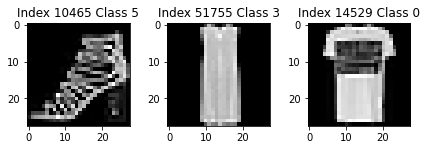

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [4]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


# Points to remember
* If using any type of neural network, normalize your input between 0-1.
* One can use various procedures to achieve this, divide by largest value (for images we use 255), subtract mean from data and then normalize, one can even augment them and use other steps for normalization.
* Normalization is important step, one could observe significant boost in performance just by having better normalization scheme.
* For targets we always use one-hot encodings.

In [5]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [6]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# Importance of weight initialization

* One reason backprop based models can perform bettter lies with the weight initialization method, one important point one should remember is that, if yur weights are initialized to be too high or low, backprop would struggle.
* Hence one should always carefully initialize weights of your model, below i have shown approach with random_normal, one can use random_uniform, truncated version of both, Xavier init and orthogonal. 
* You will find modern day NNs have achieved stable and better performance by simply switching to better init and majority of cases Xavier or Orthogonal works best.
* Always initialize your bias using zero or some small constant (ideally 0.01 or less works better). We use bias to shift the activation and in some cases it can stabalize learning, but having large bias can cause negative results.

# Loss function

* We will always cross-entropy loss for classification.

* tf softmax,
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)), this function is simply saying that it will calculate softmax for you, simply provide logits to it. 

* In other output of your forward pass directly goes this function. Now this operator will calculate or apply softmax over prediction or logits and calculate cross-entropy between prediction and target. I am using reduce_mean since we apply this over batches.
* Second is using keras
Method 1 :- This function requires logits, hence same as above you will pass logits or output variable to this function. Now remember you need from_logits = True, for this to work.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_x = cce(y_true_tf, y_pred_tf) 

* Method 2:- In this we will apply softmax to output function and then pass to CCE loss.
So the approach is 
output = tf.nn.softmax(output)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_x = cce(y_true_tf, y_pred_tf) 

# Define class to build mlp model with Adam or RMSProp or SGD optimizer

In [7]:
import sys
class MLP(object):
  def __init__(self, size_input=size_input, size_hidden1=size_hidden1, size_hidden2=size_hidden2, size_hidden3=size_hidden3, size_output=size_output, \
               reg_mode = "default",optimizer = "SGD", lr = 0.1, lambda_l2 = 0.8, dropout = 0.3, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, \
    self.reg_mode, self.optimizer, self.lr, self.lambda_l2, self.dropout, self.device = \
              size_input, size_hidden1, size_hidden2, size_hidden3, size_output, reg_mode, optimizer, lr, lambda_l2, dropout, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1))

    # He normal initialization for relu activation layers
    #self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]) * np.sqrt(2/self.size_input))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    #self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2])* np.sqrt(2/self.size_hidden1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    #self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3])* np.sqrt(2/self.size_hidden2))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
      # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

    #Variables for custom optimiser
    if optimizer == "custom":
      self.iterations = 0
      self.m = [tf.zeros_like(var, dtype=tf.float32) for var in self.variables]
      self.v = [tf.zeros_like(var, dtype=tf.float32) for var in self.variables]
      self.u = [tf.zeros_like(var, dtype=tf.float32) for var in self.variables]

  def forward(self, X, phase="train"):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X, phase)
    else:
      self.y = self.compute_output(X, phase)
      
    return self.y


  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''

    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)


    if self.reg_mode == "L2":
      #Applying L2 regularization
      para_list = [self.W1, self.W2, self.W3, self.W4]
      regularizer = sum([tf.reduce_sum(tf.square(_var)) for _var in para_list])
      loss_x = loss_x +  ((self.lambda_l2/(2 * number_of_train_examples)) * regularizer)

    return loss_x

  def backward(self, X_train, y_train):
    """
    backward pass
    """    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)

    if self.optimizer == "custom":
      self.Stochastic_optimization_update_params(grads, self.lr)

    else:
      if self.optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate = self.lr, momentum=0.9)
      
      elif self.optimizer == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate= self.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
      
      elif self.optimizer == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate= self.lr)
      else:
        print ("Invalid optimizer")
        sys.exit()
      
      optimizer.apply_gradients(zip(grads, self.variables))
            
  def compute_output(self, X, phase):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    if self.reg_mode == "dropout" and phase == "train":
      # Adding dropout on layer 2
      h2 = tf.nn.dropout(h2, self.dropout)

    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)

  def Stochastic_optimization_update_params(self, grads, lr=2e-5, beta1=0.9, beta2=0.999, beta3=0.999987, epsilon=10**-8):
    #sys.exit()
    #print (f"\n\n\n First m : {self.m}")
    self.iterations += 1
    beta1_t = beta1 ** self.iterations
    beta2_t = beta2 ** self.iterations
    beta3_t = beta3 ** self.iterations

    self.m = [beta1 * m_ele + (1 - beta1) * grad_ele for m_ele, grad_ele in zip(self.m, grads)]
    self.v = [beta2 * v_ele + (1 - beta2) * (grad_ele ** 2) for v_ele, grad_ele in zip(self.v, grads)]
    self.u = [beta3 * u_ele + (1 - beta3) * (grad_ele ** 3) for u_ele, grad_ele in zip(self.u, grads)]

    m_hat =[m_t / (1 - beta1_t) for m_t in self.m]
    v_hat =[v_t / (1 - beta2_t) for v_t in self.v]
    u_hat =[u_t / (1 - beta3_t) for u_t in self.u]

    v_hat_root2 = [tf.sign(v_hat_ele) * tf.sqrt(tf.abs(v_hat_ele)) for v_hat_ele in v_hat]
    u_hat_root3 = [tf.sign(u_hat_ele) * tf.pow(tf.abs(u_hat_ele), (1/3)) for u_hat_ele in u_hat]

    sum_denom = [(v_hat_root2_ele + u_hat_root3_ele * epsilon) + epsilon for v_hat_root2_ele, u_hat_root3_ele in zip(v_hat_root2, u_hat_root3)]
    new_vars_t = [vars_ele - lr * (m_hat_ele / sum_denom_ele) for vars_ele, m_hat_ele, sum_denom_ele  in zip(self.variables, m_hat, sum_denom)]

    #print (f"Variable: {self.variables}")
    for i in range(len(self.variables)):
      self.variables[i].assign(new_vars_t[i])


In [8]:
def train_model(mlp, num_epochs, seed, shuffle_size, batch_size):
  time_start = time.time()
  train_acc_list = []
  val_acc_list = []
  train_cce_list = []
  for epoch in range(num_epochs):
    loss_total = tf.zeros([1,1], dtype=tf.float32)    
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(shuffle_size, seed=epoch*(seed)).batch(batch_size)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp.forward(inputs) 
      loss_total = loss_total + mlp.loss(preds, outputs)
      mlp.backward(inputs, outputs)

    preds = mlp.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    train_acc_list.append(ds)
    print('\nTrain Accuracy: {:.4f}'.format(ds))

    avg_cce = np.sum(loss_total) / X_train.shape[0]
    train_cce_list.append(avg_cce)
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, avg_cce))

    preds_val = mlp.forward(X_val, "test")
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()
    val_acc_list.append(cur_val_acc)
    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    #plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

          
  time_taken = time.time() - time_start
      
  # Validate model
  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  return time_taken, train_acc_list, val_acc_list, train_cce_list
  #For per epoch_time = Total_Time / Number_of_epochs

In [9]:
def test_model(model):
# Initialize
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  correct_prediction = tf.Variable(0, dtype=tf.float32)
  #test_loss_total = 0.0
  for inputs, outputs in test_ds:
    preds = model.forward(inputs, "test")
    test_loss_total = test_loss_total + model.loss(preds, outputs)
  
  avg_test_loss = np.sum(test_loss_total.numpy()) / X_test.shape[0]
  print('Test loss: {:.4f}'.format(avg_test_loss))

  # Test model
  preds_test = model.forward(X_test,"test")
  preds_test = tf.nn.softmax(preds_test)
  correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_test_acc = accuracy.numpy()
  print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))
  return avg_test_loss, cur_test_acc

In [10]:
NUM_EPOCHS = 20
seed = 1234
shuffle_size = 25
batch_size=128
np.random.seed(seed)
tf.random.set_seed(seed)

# Models with no regularization - default mode
## SGD

In [ ]:
model_default_sgd = MLP(reg_mode="default", optimizer="SGD", lr=0.1,   device="gpu")
time_to_train, train_acclist, val_acclist, train_ccelist  = train_model(model_default_sgd, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
time_to_train, train_acclist, val_acclist, train_ccelist

## Adam

In [ ]:
model_default_adam = MLP(reg_mode="default", optimizer="Adam", lr=0.001, device="gpu")
train_model(model_default_adam, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## RMSProp

In [ ]:
model_default_rmsprop = MLP(reg_mode="default", optimizer="RMSprop", lr=0.001, device="gpu")
train_model(model_default_rmsprop, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## Custom optimizer 

In [ ]:
model_default_custom = MLP(reg_mode="default", optimizer="custom", lr=0.001, device="gpu")
train_model(model_default_custom, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
#saving models with no regularization
import pickle
models = [model_default_sgd, model_default_adam, model_default_rmsprop, model_default_custom]
files = ["model_default_sgd.pickle", "model_default_adam.pickle", "model_default_rmsprop.pickle", "default_custom_variables.pickle"]
for model, f in zip(models, files):
  vars = model.variables
  with open(f, 'wb') as handle:
    pickle.dump(vars, handle)

In [ ]:
#Loading from saved variables
with open('default_custom_variables.pickle', 'rb') as handle:
    b = pickle.load(handle)

## Adam - L2 reg

In [ ]:
model_l2_adam = MLP(reg_mode="L2", optimizer="Adam", lr=0.001, lambda_l2=0.7,device="gpu")
train_model(model_l2_adam, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## SGD - L2 Reg

In [ ]:
model_l2_sgd = MLP(reg_mode="L2", optimizer="SGD", lr=0.1, lambda_l2=0.7,device="gpu")
train_model(model_l2_sgd, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## RMSprop - L2 reg

In [ ]:
model_l2_rmsprop = MLP(reg_mode="L2", optimizer="RMSprop", lr=0.001, lambda_l2=0.7,device="gpu")
train_model(model_l2_rmsprop, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## Custom opt - L2 reg

In [ ]:
model_l2_custom = MLP(reg_mode="L2", optimizer="custom", lr=0.001, lambda_l2=0.7, device="gpu")
train_model(model_l2_custom, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

## SGD - dropout

In [ ]:
model_dropout_sgd = MLP(reg_mode="dropout", optimizer="SGD", lr=0.1, dropout=0.3, device="gpu")
train_model(model_dropout_sgd, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
model_dropout_custom = MLP(reg_mode="dropout", optimizer="custom", lr=0.001, dropout=0.3, device="gpu")
train_model(model_dropout_custom, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
model_dropout_rmsprop = MLP(reg_mode="dropout", optimizer="RMSprop", lr=0.001, device="gpu")
train_model(model_dropout_rmsprop, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
model_dropout_adam = MLP(reg_mode="dropout", optimizer="Adam", lr=0.001, dropout=0.3,device="gpu")
train_model(model_dropout_adam, NUM_EPOCHS, seed = seed, shuffle_size=shuffle_size, batch_size=batch_size)

In [ ]:
#saving models with l2 regularization
import pickle
models = [model_l2_sgd, model_l2_adam, model_l2_rmsprop, model_l2_custom]
files = ["model_l2_sgd.pickle", "model_l2_adam.pickle", "model_l2_rmsprop.pickle", "model_l2_custom.pickle"]
for model, f in zip(models, files):
  vars = model.variables
  with open(f, 'wb') as handle:
    pickle.dump(vars, handle)

In [ ]:
#saving models with dropout regularization
import pickle
models = [model_dropout_sgd, model_dropout_adam, model_dropout_rmsprop, model_dropout_custom]
files = ["model_dropout_sgd.pickle", "model_dropout_adam.pickle", "model_dropout_rmsprop.pickle", "model_dropout_custom.pickle"]
for model, f in zip(models, files):
  vars = model.variables
  with open(f, 'wb') as handle:
    pickle.dump(vars, handle)

In [ ]:
test_model(model_default_custom)

Test loss: 0.0018

Test Accuracy: 0.88


In [ ]:
test_model(model_dropout_custom)

Test loss: 0.0017

Test Accuracy: 0.87


In [ ]:
test_model(model_l2_custom)

Test loss: 0.0017

Test Accuracy: 0.88


In [ ]:
test_model(model_dropout_rmsprop)

Test loss: 0.0096

Test Accuracy: 0.34


In [ ]:
test_model(model_l2_rmsprop)

Test loss: 0.0032

Test Accuracy: 0.80


(0.0031944526672363282, 0.8044)

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(512)
avg_testloss, cur_testacc = test_model(model_default_sgd)

Test loss: 0.0007

Test Accuracy: 0.87


In [ ]:
avg_testloss, cur_testacc

(0.0007101140975952149, 0.8733)

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(512)
test_model(model_default_rmsprop)

Test loss: 0.0124

Test Accuracy: 0.81


(0.012434486389160157, 0.8092)

# Inference - Running across 10 trials

In [21]:
# Obtaining inferences for all three models - 10 iteration per model
from tqdm import tqdm
import json
############## Setting values as per dataset ##############
size_input = 784
size_hidden_1 = 128 
size_hidden_2 = 128
size_output = 10 
number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]
print (f"{number_of_test_examples},{number_of_train_examples}")

########################################################
'''
Additional steps done above
1. Reshape to flatten
2. Normalization
3. One hot encoding
'''

#######################################################
reg_type_list = ["default", "L2", "dropout"]

inference_stats_total_dict = {
    "custom":{},
    "Adam":{},
    "RMSprop":{},
    "SGD":{}
}

lambda_val = 0.7
dropout_val = 0.3
NUM_EPOCHS = 10 # reduced to 10 to save overall time
#NUM_EPOCHS = 2
random_seeds = list(np.random.randint(low=1000, high=100000, size=10))
#random_seeds = list(np.random.randint(low=2000, high=4000, size=2))
print (f"Random seeds used in the test : {random_seeds}")
inf_iters = len(random_seeds)
device_type = 'gpu'
shuffle_size = 25
batch_size = 128
#batch_size = 512
learning_rates = {
    "SGD": 0.1,
    "Adam": 0.001,
    "RMSprop": 0.001,
    "custom": 0.001
}


optimizers = learning_rates.keys()

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(256)
####################################################

for optimizer in optimizers:
  inference_stats_dict = {
    "default":{}, 
    "L2": {}, 
    "dropout": {}
  }
  print (f"#####Running trials for optimizer: {optimizer.upper()}#####")
  for reg_type in reg_type_list:
    print (f"## START: Current Model: {reg_type} ##")
    test_cce_list = []
    test_acc_list = []
    cpu_time_list = []
    train_acc_list_dict = {}
    val_acc_list_dict = {}
    train_cce_list_dict = {}

    for iter in tqdm(range(inf_iters)):
      print(f"\n** Inference Iteration: {iter} **")
      cur_seed = random_seeds[iter]
      print (f"\n#Training {reg_type} model, optimizer {optimizer} with seed {cur_seed}#")
      np.random.seed(cur_seed)
      tf.random.set_seed(cur_seed)


      # Model initialization as per regularization type - regularization code triggers only if knob is on
      mlp = MLP(size_input, size_hidden_1, size_hidden_2, size_output, reg_mode = reg_type, lambda_l2 = lambda_val, dropout = dropout_val, lr = learning_rates[optimizer], optimizer=optimizer, device=device_type)
      cputime, train_acc_list, val_acc_list, train_cce_list = \
                train_model(mlp, NUM_EPOCHS, seed=cur_seed, shuffle_size=shuffle_size, batch_size=batch_size)

      train_acc_list_dict[cur_seed] = train_acc_list
      val_acc_list_dict[cur_seed] = val_acc_list
      train_cce_list_dict[cur_seed] = train_cce_list
      cpu_time_list.append(cputime)

      # Testing the data
      (cce_test, acc_test) = test_model(mlp)
      print(f"seed: {cur_seed}, Test Cross Entropy loss: {cce_test}, Accuracy: {acc_test}")

      test_cce_list.append(cce_test)
      test_acc_list.append(acc_test)
      
    inference_stats_dict[reg_type]["test_cce_list"] = test_cce_list
    inference_stats_dict[reg_type]["test_acc_list"] = test_acc_list
    inference_stats_dict[reg_type]["cputime_list"] = cpu_time_list
    inference_stats_dict[reg_type]["train_acc_list_dict"] = train_acc_list_dict
    inference_stats_dict[reg_type]["val_acc_list_dict"] = val_acc_list_dict
    inference_stats_dict[reg_type]["train_cce_list_dict"] = train_cce_list_dict

    print (f"## END: Current Model: {reg_type}##")
    print (f"Current inference results: \n{inference_stats_dict}")
  print (f"Inference stat dict for optimizer : {optimizer}: \n{inference_stats_dict}")
  inference_stats_total_dict[optimizer] = inference_stats_dict
  print (f"Current status of dictionary: {inference_stats_total_dict}")
  with open('fmnist_stats.json', 'w') as convert_file:
     convert_file.write(json.dumps(str(inference_stats_total_dict)))
  ################################   

10000,50000
Random seeds used in the test : [82195, 12437, 76843, 63622, 71168, 4102, 14619, 42867, 81035, 8447]
#####Running trials for optimizer: SGD#####
## START: Current Model: default ##


  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training default model, optimizer SGD with seed 82195#

Train Accuracy: 0.7899
Number of Epoch = 1 - Average Cross Entropy:= 0.0069668798828125 

Validation Accuracy: 0.7827

Train Accuracy: 0.8408
Number of Epoch = 2 - Average Cross Entropy:= 0.004066061401367188 

Validation Accuracy: 0.8338

Train Accuracy: 0.8559
Number of Epoch = 3 - Average Cross Entropy:= 0.0034727163696289063 

Validation Accuracy: 0.8460

Train Accuracy: 0.8618
Number of Epoch = 4 - Average Cross Entropy:= 0.0031615036010742186 

Validation Accuracy: 0.8519

Train Accuracy: 0.8644
Number of Epoch = 5 - Average Cross Entropy:= 0.0029587005615234374 

Validation Accuracy: 0.8538

Train Accuracy: 0.8777
Number of Epoch = 6 - Average Cross Entropy:= 0.00279482666015625 

Validation Accuracy: 0.8657

Train Accuracy: 0.8822
Number of Epoch = 7 - Average Cross Entropy:= 0.0026641693115234373 

Validation Accuracy: 0.8669

Train Accuracy: 0.8860
Number of Epoch = 8 - Average Cross Entro

 10%|█         | 1/10 [01:17<11:41, 77.91s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 82195, Test Cross Entropy loss: 0.0015127672195434571, Accuracy: 0.8679999709129333

** Inference Iteration: 1 **

#Training default model, optimizer SGD with seed 12437#

Train Accuracy: 0.7848
Number of Epoch = 1 - Average Cross Entropy:= 0.006769971313476563 

Validation Accuracy: 0.7805

Train Accuracy: 0.8176
Number of Epoch = 2 - Average Cross Entropy:= 0.004065625 

Validation Accuracy: 0.8076

Train Accuracy: 0.8565
Number of Epoch = 3 - Average Cross Entropy:= 0.0035033132934570313 

Validation Accuracy: 0.8468

Train Accuracy: 0.8525
Number of Epoch = 4 - Average Cross Entropy:= 0.0031937908935546874 

Validation Accuracy: 0.8414

Train Accuracy: 0.8637
Number of Epoch = 5 - Average Cross Entropy:= 0.002980880126953125 

Validation Accuracy: 0.8523

Train Accuracy: 0.8577
Number of Epoch = 6 - Average Cross Entropy:= 0.0028148477172851563 

Validation Accuracy: 0.8444

Train Accuracy: 0.8754
Number of Epoch = 7 - Average Cross Entr

 20%|██        | 2/10 [02:34<10:18, 77.35s/it]

Test loss: 0.0016

Test Accuracy: 0.86
seed: 12437, Test Cross Entropy loss: 0.0015957701683044433, Accuracy: 0.8557000160217285

** Inference Iteration: 2 **

#Training default model, optimizer SGD with seed 76843#

Train Accuracy: 0.7130
Number of Epoch = 1 - Average Cross Entropy:= 0.0071701007080078125 

Validation Accuracy: 0.7046

Train Accuracy: 0.8255
Number of Epoch = 2 - Average Cross Entropy:= 0.0042385791015625 

Validation Accuracy: 0.8121

Train Accuracy: 0.8416
Number of Epoch = 3 - Average Cross Entropy:= 0.00357831787109375 

Validation Accuracy: 0.8311

Train Accuracy: 0.8472
Number of Epoch = 4 - Average Cross Entropy:= 0.0032527139282226562 

Validation Accuracy: 0.8365

Train Accuracy: 0.8674
Number of Epoch = 5 - Average Cross Entropy:= 0.0030275244140625 

Validation Accuracy: 0.8539

Train Accuracy: 0.8717
Number of Epoch = 6 - Average Cross Entropy:= 0.002852872009277344 

Validation Accuracy: 0.8579

Train Accuracy: 0.8775
Number of Epoch = 7 - Average Cross E

 30%|███       | 3/10 [03:51<08:59, 77.05s/it]

Test loss: 0.0016

Test Accuracy: 0.85
seed: 76843, Test Cross Entropy loss: 0.0015861333847045898, Accuracy: 0.8513000011444092

** Inference Iteration: 3 **

#Training default model, optimizer SGD with seed 63622#

Train Accuracy: 0.8014
Number of Epoch = 1 - Average Cross Entropy:= 0.006914061279296875 

Validation Accuracy: 0.7929

Train Accuracy: 0.8307
Number of Epoch = 2 - Average Cross Entropy:= 0.0040395285034179685 

Validation Accuracy: 0.8196

Train Accuracy: 0.8501
Number of Epoch = 3 - Average Cross Entropy:= 0.00348429931640625 

Validation Accuracy: 0.8427

Train Accuracy: 0.8552
Number of Epoch = 4 - Average Cross Entropy:= 0.0031856451416015625 

Validation Accuracy: 0.8447

Train Accuracy: 0.8660
Number of Epoch = 5 - Average Cross Entropy:= 0.002958310241699219 

Validation Accuracy: 0.8549

Train Accuracy: 0.8591
Number of Epoch = 6 - Average Cross Entropy:= 0.0027885821533203126 

Validation Accuracy: 0.8470

Train Accuracy: 0.8675
Number of Epoch = 7 - Average Cr

 40%|████      | 4/10 [05:08<07:41, 76.95s/it]

Test loss: 0.0017

Test Accuracy: 0.85
seed: 63622, Test Cross Entropy loss: 0.0016635181427001953, Accuracy: 0.8481000065803528

** Inference Iteration: 4 **

#Training default model, optimizer SGD with seed 71168#

Train Accuracy: 0.7455
Number of Epoch = 1 - Average Cross Entropy:= 0.006862582397460937 

Validation Accuracy: 0.7387

Train Accuracy: 0.8092
Number of Epoch = 2 - Average Cross Entropy:= 0.0042207330322265625 

Validation Accuracy: 0.7965

Train Accuracy: 0.8397
Number of Epoch = 3 - Average Cross Entropy:= 0.003585776672363281 

Validation Accuracy: 0.8319

Train Accuracy: 0.8566
Number of Epoch = 4 - Average Cross Entropy:= 0.0032598651123046875 

Validation Accuracy: 0.8471

Train Accuracy: 0.8565
Number of Epoch = 5 - Average Cross Entropy:= 0.0030417684936523436 

Validation Accuracy: 0.8476

Train Accuracy: 0.8687
Number of Epoch = 6 - Average Cross Entropy:= 0.0028712298583984377 

Validation Accuracy: 0.8515

Train Accuracy: 0.8670
Number of Epoch = 7 - Average 

 50%|█████     | 5/10 [06:24<06:23, 76.80s/it]

Test loss: 0.0016

Test Accuracy: 0.85
seed: 71168, Test Cross Entropy loss: 0.0016117774963378907, Accuracy: 0.8518999814987183

** Inference Iteration: 5 **

#Training default model, optimizer SGD with seed 4102#

Train Accuracy: 0.7707
Number of Epoch = 1 - Average Cross Entropy:= 0.006928360595703125 

Validation Accuracy: 0.7692

Train Accuracy: 0.8095
Number of Epoch = 2 - Average Cross Entropy:= 0.004116905517578125 

Validation Accuracy: 0.8032

Train Accuracy: 0.8446
Number of Epoch = 3 - Average Cross Entropy:= 0.003524093017578125 

Validation Accuracy: 0.8389

Train Accuracy: 0.8535
Number of Epoch = 4 - Average Cross Entropy:= 0.0031952371215820314 

Validation Accuracy: 0.8420

Train Accuracy: 0.8708
Number of Epoch = 5 - Average Cross Entropy:= 0.002969640197753906 

Validation Accuracy: 0.8602

Train Accuracy: 0.8735
Number of Epoch = 6 - Average Cross Entropy:= 0.002797274169921875 

Validation Accuracy: 0.8620

Train Accuracy: 0.8763
Number of Epoch = 7 - Average Cros

 60%|██████    | 6/10 [07:41<05:07, 76.81s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 4102, Test Cross Entropy loss: 0.001515087890625, Accuracy: 0.8633000254631042

** Inference Iteration: 6 **

#Training default model, optimizer SGD with seed 14619#

Train Accuracy: 0.7388
Number of Epoch = 1 - Average Cross Entropy:= 0.00688375244140625 

Validation Accuracy: 0.7309

Train Accuracy: 0.8205
Number of Epoch = 2 - Average Cross Entropy:= 0.004205483093261719 

Validation Accuracy: 0.8111

Train Accuracy: 0.8479
Number of Epoch = 3 - Average Cross Entropy:= 0.003588706359863281 

Validation Accuracy: 0.8379

Train Accuracy: 0.8565
Number of Epoch = 4 - Average Cross Entropy:= 0.003256898498535156 

Validation Accuracy: 0.8503

Train Accuracy: 0.8453
Number of Epoch = 5 - Average Cross Entropy:= 0.0030426400756835936 

Validation Accuracy: 0.8375

Train Accuracy: 0.8695
Number of Epoch = 6 - Average Cross Entropy:= 0.002868061828613281 

Validation Accuracy: 0.8610

Train Accuracy: 0.8728
Number of Epoch = 7 - Average Cross Ent

 70%|███████   | 7/10 [08:58<03:50, 76.84s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 14619, Test Cross Entropy loss: 0.0015236409187316894, Accuracy: 0.8615999817848206

** Inference Iteration: 7 **

#Training default model, optimizer SGD with seed 42867#

Train Accuracy: 0.8009
Number of Epoch = 1 - Average Cross Entropy:= 0.0069947021484375 

Validation Accuracy: 0.7950

Train Accuracy: 0.8158
Number of Epoch = 2 - Average Cross Entropy:= 0.003973780212402344 

Validation Accuracy: 0.8060

Train Accuracy: 0.8456
Number of Epoch = 3 - Average Cross Entropy:= 0.0034569766235351563 

Validation Accuracy: 0.8360

Train Accuracy: 0.8587
Number of Epoch = 4 - Average Cross Entropy:= 0.003184946594238281 

Validation Accuracy: 0.8453

Train Accuracy: 0.8642
Number of Epoch = 5 - Average Cross Entropy:= 0.002976121520996094 

Validation Accuracy: 0.8484

Train Accuracy: 0.8772
Number of Epoch = 6 - Average Cross Entropy:= 0.0028073016357421875 

Validation Accuracy: 0.8606

Train Accuracy: 0.8779
Number of Epoch = 7 - Average Cros

 80%|████████  | 8/10 [10:15<02:33, 76.89s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 42867, Test Cross Entropy loss: 0.001523642349243164, Accuracy: 0.86080002784729

** Inference Iteration: 8 **

#Training default model, optimizer SGD with seed 81035#

Train Accuracy: 0.7971
Number of Epoch = 1 - Average Cross Entropy:= 0.007491405639648437 

Validation Accuracy: 0.7902

Train Accuracy: 0.8274
Number of Epoch = 2 - Average Cross Entropy:= 0.004169845275878907 

Validation Accuracy: 0.8226

Train Accuracy: 0.8430
Number of Epoch = 3 - Average Cross Entropy:= 0.0035484307861328125 

Validation Accuracy: 0.8325

Train Accuracy: 0.8590
Number of Epoch = 4 - Average Cross Entropy:= 0.0032355438232421875 

Validation Accuracy: 0.8452

Train Accuracy: 0.8588
Number of Epoch = 5 - Average Cross Entropy:= 0.00301363525390625 

Validation Accuracy: 0.8467

Train Accuracy: 0.8623
Number of Epoch = 6 - Average Cross Entropy:= 0.0028588800048828123 

Validation Accuracy: 0.8446

Train Accuracy: 0.8723
Number of Epoch = 7 - Average Cross

 90%|█████████ | 9/10 [11:32<01:16, 76.98s/it]

Test loss: 0.0016

Test Accuracy: 0.86
seed: 81035, Test Cross Entropy loss: 0.001563045883178711, Accuracy: 0.857699990272522

** Inference Iteration: 9 **

#Training default model, optimizer SGD with seed 8447#

Train Accuracy: 0.8117
Number of Epoch = 1 - Average Cross Entropy:= 0.007143883666992187 

Validation Accuracy: 0.8059

Train Accuracy: 0.8286
Number of Epoch = 2 - Average Cross Entropy:= 0.00405794921875 

Validation Accuracy: 0.8243

Train Accuracy: 0.8461
Number of Epoch = 3 - Average Cross Entropy:= 0.0034919970703125 

Validation Accuracy: 0.8385

Train Accuracy: 0.8400
Number of Epoch = 4 - Average Cross Entropy:= 0.0031989584350585938 

Validation Accuracy: 0.8290

Train Accuracy: 0.8601
Number of Epoch = 5 - Average Cross Entropy:= 0.0029736764526367187 

Validation Accuracy: 0.8490

Train Accuracy: 0.8683
Number of Epoch = 6 - Average Cross Entropy:= 0.00281845703125 

Validation Accuracy: 0.8546

Train Accuracy: 0.8728
Number of Epoch = 7 - Average Cross Entropy:=

100%|██████████| 10/10 [12:49<00:00, 76.96s/it]


Test loss: 0.0015

Test Accuracy: 0.86
seed: 8447, Test Cross Entropy loss: 0.0015477230072021484, Accuracy: 0.862500011920929
## END: Current Model: default##
Current inference results: 
{'default': {'test_cce_list': [0.0015127672195434571, 0.0015957701683044433, 0.0015861333847045898, 0.0016635181427001953, 0.0016117774963378907, 0.001515087890625, 0.0015236409187316894, 0.001523642349243164, 0.001563045883178711, 0.0015477230072021484], 'test_acc_list': [0.868, 0.8557, 0.8513, 0.8481, 0.8519, 0.8633, 0.8616, 0.8608, 0.8577, 0.8625], 'cputime_list': [77.65503478050232, 76.70391988754272, 76.45030379295349, 76.52981638908386, 76.27921414375305, 76.60599517822266, 76.65074133872986, 76.73265552520752, 76.93382596969604, 76.57074284553528], 'train_acc_list_dict': {82195: [0.7899199724197388, 0.8407999873161316, 0.8559399843215942, 0.8617799878120422, 0.864359974861145, 0.8776599764823914, 0.8822399973869324, 0.8860399723052979, 0.8907600045204163, 0.8944200277328491], 12437: [0.78479999

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training L2 model, optimizer SGD with seed 82195#

Train Accuracy: 0.7877
Number of Epoch = 1 - Average Cross Entropy:= 0.007036199340820313 

Validation Accuracy: 0.7801

Train Accuracy: 0.8416
Number of Epoch = 2 - Average Cross Entropy:= 0.004127861633300782 

Validation Accuracy: 0.8348

Train Accuracy: 0.8555
Number of Epoch = 3 - Average Cross Entropy:= 0.0035326422119140626 

Validation Accuracy: 0.8462

Train Accuracy: 0.8596
Number of Epoch = 4 - Average Cross Entropy:= 0.003222412109375 

Validation Accuracy: 0.8505

Train Accuracy: 0.8704
Number of Epoch = 5 - Average Cross Entropy:= 0.0030261444091796877 

Validation Accuracy: 0.8585

Train Accuracy: 0.8783
Number of Epoch = 6 - Average Cross Entropy:= 0.002866170349121094 

Validation Accuracy: 0.8654

Train Accuracy: 0.8811
Number of Epoch = 7 - Average Cross Entropy:= 0.0027341461181640625 

Validation Accuracy: 0.8648

Train Accuracy: 0.8818
Number of Epoch = 8 - Average Cross Entropy:= 0

 10%|█         | 1/10 [01:27<13:07, 87.45s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 82195, Test Cross Entropy loss: 0.001528959560394287, Accuracy: 0.8683000206947327

** Inference Iteration: 1 **

#Training L2 model, optimizer SGD with seed 12437#

Train Accuracy: 0.7831
Number of Epoch = 1 - Average Cross Entropy:= 0.006834073486328125 

Validation Accuracy: 0.7771

Train Accuracy: 0.8189
Number of Epoch = 2 - Average Cross Entropy:= 0.004127841491699219 

Validation Accuracy: 0.8098

Train Accuracy: 0.8563
Number of Epoch = 3 - Average Cross Entropy:= 0.0035675421142578123 

Validation Accuracy: 0.8467

Train Accuracy: 0.8505
Number of Epoch = 4 - Average Cross Entropy:= 0.0032529510498046873 

Validation Accuracy: 0.8405

Train Accuracy: 0.8637
Number of Epoch = 5 - Average Cross Entropy:= 0.003047060546875 

Validation Accuracy: 0.8527

Train Accuracy: 0.8579
Number of Epoch = 6 - Average Cross Entropy:= 0.0028773858642578126 

Validation Accuracy: 0.8449

Train Accuracy: 0.8761
Number of Epoch = 7 - Average Cross Entr

 20%|██        | 2/10 [02:54<11:39, 87.43s/it]

Test loss: 0.0016

Test Accuracy: 0.86
seed: 12437, Test Cross Entropy loss: 0.0016197046279907226, Accuracy: 0.857200026512146

** Inference Iteration: 2 **

#Training L2 model, optimizer SGD with seed 76843#

Train Accuracy: 0.7141
Number of Epoch = 1 - Average Cross Entropy:= 0.007234664306640625 

Validation Accuracy: 0.7062

Train Accuracy: 0.8292
Number of Epoch = 2 - Average Cross Entropy:= 0.0043109930419921874 

Validation Accuracy: 0.8165

Train Accuracy: 0.8432
Number of Epoch = 3 - Average Cross Entropy:= 0.003642135314941406 

Validation Accuracy: 0.8338

Train Accuracy: 0.8477
Number of Epoch = 4 - Average Cross Entropy:= 0.003322297058105469 

Validation Accuracy: 0.8358

Train Accuracy: 0.8678
Number of Epoch = 5 - Average Cross Entropy:= 0.0030915109252929686 

Validation Accuracy: 0.8549

Train Accuracy: 0.8726
Number of Epoch = 6 - Average Cross Entropy:= 0.0029222549438476563 

Validation Accuracy: 0.8599

Train Accuracy: 0.8770
Number of Epoch = 7 - Average Cross E

 30%|███       | 3/10 [04:21<10:10, 87.25s/it]

Test loss: 0.0016

Test Accuracy: 0.85
seed: 76843, Test Cross Entropy loss: 0.0016183221817016602, Accuracy: 0.8518999814987183

** Inference Iteration: 3 **

#Training L2 model, optimizer SGD with seed 63622#

Train Accuracy: 0.8003
Number of Epoch = 1 - Average Cross Entropy:= 0.00698045654296875 

Validation Accuracy: 0.7915

Train Accuracy: 0.8320
Number of Epoch = 2 - Average Cross Entropy:= 0.00410528564453125 

Validation Accuracy: 0.8209

Train Accuracy: 0.8480
Number of Epoch = 3 - Average Cross Entropy:= 0.0035504647827148436 

Validation Accuracy: 0.8423

Train Accuracy: 0.8534
Number of Epoch = 4 - Average Cross Entropy:= 0.003259612731933594 

Validation Accuracy: 0.8449

Train Accuracy: 0.8656
Number of Epoch = 5 - Average Cross Entropy:= 0.003031650390625 

Validation Accuracy: 0.8550

Train Accuracy: 0.8676
Number of Epoch = 6 - Average Cross Entropy:= 0.0028613186645507814 

Validation Accuracy: 0.8599

Train Accuracy: 0.8607
Number of Epoch = 7 - Average Cross Entrop

 40%|████      | 4/10 [05:48<08:42, 87.04s/it]

Test loss: 0.0017

Test Accuracy: 0.85
seed: 63622, Test Cross Entropy loss: 0.0016874523162841797, Accuracy: 0.8478000164031982

** Inference Iteration: 4 **

#Training L2 model, optimizer SGD with seed 71168#

Train Accuracy: 0.7432
Number of Epoch = 1 - Average Cross Entropy:= 0.0069304498291015626 

Validation Accuracy: 0.7377

Train Accuracy: 0.8059
Number of Epoch = 2 - Average Cross Entropy:= 0.004293074340820312 

Validation Accuracy: 0.7958

Train Accuracy: 0.8415
Number of Epoch = 3 - Average Cross Entropy:= 0.0036591278076171874 

Validation Accuracy: 0.8336

Train Accuracy: 0.8564
Number of Epoch = 4 - Average Cross Entropy:= 0.0033278570556640624 

Validation Accuracy: 0.8466

Train Accuracy: 0.8584
Number of Epoch = 5 - Average Cross Entropy:= 0.0031145773315429687 

Validation Accuracy: 0.8485

Train Accuracy: 0.8672
Number of Epoch = 6 - Average Cross Entropy:= 0.0029341680908203127 

Validation Accuracy: 0.8503

Train Accuracy: 0.8653
Number of Epoch = 7 - Average Cros

 50%|█████     | 5/10 [07:15<07:15, 87.01s/it]

Test loss: 0.0017

Test Accuracy: 0.85
seed: 71168, Test Cross Entropy loss: 0.001658793830871582, Accuracy: 0.8508999943733215

** Inference Iteration: 5 **

#Training L2 model, optimizer SGD with seed 4102#

Train Accuracy: 0.7765
Number of Epoch = 1 - Average Cross Entropy:= 0.006992218627929687 

Validation Accuracy: 0.7751

Train Accuracy: 0.8098
Number of Epoch = 2 - Average Cross Entropy:= 0.004177865295410157 

Validation Accuracy: 0.8041

Train Accuracy: 0.8463
Number of Epoch = 3 - Average Cross Entropy:= 0.0035881277465820314 

Validation Accuracy: 0.8406

Train Accuracy: 0.8504
Number of Epoch = 4 - Average Cross Entropy:= 0.003253382873535156 

Validation Accuracy: 0.8406

Train Accuracy: 0.8704
Number of Epoch = 5 - Average Cross Entropy:= 0.003037992858886719 

Validation Accuracy: 0.8596

Train Accuracy: 0.8699
Number of Epoch = 6 - Average Cross Entropy:= 0.0028680865478515625 

Validation Accuracy: 0.8560

Train Accuracy: 0.8726
Number of Epoch = 7 - Average Cross Ent

 60%|██████    | 6/10 [08:42<05:47, 86.91s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 4102, Test Cross Entropy loss: 0.0015389594078063964, Accuracy: 0.8641999959945679

** Inference Iteration: 6 **

#Training L2 model, optimizer SGD with seed 14619#

Train Accuracy: 0.7414
Number of Epoch = 1 - Average Cross Entropy:= 0.00694972412109375 

Validation Accuracy: 0.7332

Train Accuracy: 0.8186
Number of Epoch = 2 - Average Cross Entropy:= 0.004273184204101562 

Validation Accuracy: 0.8081

Train Accuracy: 0.8473
Number of Epoch = 3 - Average Cross Entropy:= 0.003663052673339844 

Validation Accuracy: 0.8387

Train Accuracy: 0.8561
Number of Epoch = 4 - Average Cross Entropy:= 0.0033309048461914064 

Validation Accuracy: 0.8485

Train Accuracy: 0.8420
Number of Epoch = 5 - Average Cross Entropy:= 0.0031154721069335937 

Validation Accuracy: 0.8326

Train Accuracy: 0.8694
Number of Epoch = 6 - Average Cross Entropy:= 0.0029396987915039064 

Validation Accuracy: 0.8597

Train Accuracy: 0.8732
Number of Epoch = 7 - Average Cross En

 70%|███████   | 7/10 [10:08<04:20, 86.78s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 14619, Test Cross Entropy loss: 0.0015490577697753905, Accuracy: 0.8633000254631042

** Inference Iteration: 7 **

#Training L2 model, optimizer SGD with seed 42867#

Train Accuracy: 0.8025
Number of Epoch = 1 - Average Cross Entropy:= 0.007063078002929687 

Validation Accuracy: 0.7975

Train Accuracy: 0.8179
Number of Epoch = 2 - Average Cross Entropy:= 0.004050125122070312 

Validation Accuracy: 0.8078

Train Accuracy: 0.8491
Number of Epoch = 3 - Average Cross Entropy:= 0.003523670654296875 

Validation Accuracy: 0.8370

Train Accuracy: 0.8603
Number of Epoch = 4 - Average Cross Entropy:= 0.003258150634765625 

Validation Accuracy: 0.8485

Train Accuracy: 0.8662
Number of Epoch = 5 - Average Cross Entropy:= 0.0030450836181640626 

Validation Accuracy: 0.8510

Train Accuracy: 0.8766
Number of Epoch = 6 - Average Cross Entropy:= 0.0028760333251953126 

Validation Accuracy: 0.8618

Train Accuracy: 0.8760
Number of Epoch = 7 - Average Cross E

 80%|████████  | 8/10 [11:35<02:53, 86.76s/it]

Test loss: 0.0016

Test Accuracy: 0.86
seed: 42867, Test Cross Entropy loss: 0.001552109432220459, Accuracy: 0.8621000051498413

** Inference Iteration: 8 **

#Training L2 model, optimizer SGD with seed 81035#

Train Accuracy: 0.7997
Number of Epoch = 1 - Average Cross Entropy:= 0.007555146484375 

Validation Accuracy: 0.7923

Train Accuracy: 0.8292
Number of Epoch = 2 - Average Cross Entropy:= 0.004233900451660156 

Validation Accuracy: 0.8254

Train Accuracy: 0.8396
Number of Epoch = 3 - Average Cross Entropy:= 0.003619659118652344 

Validation Accuracy: 0.8286

Train Accuracy: 0.8527
Number of Epoch = 4 - Average Cross Entropy:= 0.003304977722167969 

Validation Accuracy: 0.8380

Train Accuracy: 0.8636
Number of Epoch = 5 - Average Cross Entropy:= 0.0030824444580078124 

Validation Accuracy: 0.8510

Train Accuracy: 0.8622
Number of Epoch = 6 - Average Cross Entropy:= 0.002924178466796875 

Validation Accuracy: 0.8462

Train Accuracy: 0.8738
Number of Epoch = 7 - Average Cross Entrop

 90%|█████████ | 9/10 [13:01<01:26, 86.65s/it]

Test loss: 0.0016

Test Accuracy: 0.86
seed: 81035, Test Cross Entropy loss: 0.0015825329780578613, Accuracy: 0.859499990940094

** Inference Iteration: 9 **

#Training L2 model, optimizer SGD with seed 8447#

Train Accuracy: 0.8108
Number of Epoch = 1 - Average Cross Entropy:= 0.0072104119873046876 

Validation Accuracy: 0.8038

Train Accuracy: 0.8263
Number of Epoch = 2 - Average Cross Entropy:= 0.00412067626953125 

Validation Accuracy: 0.8213

Train Accuracy: 0.8460
Number of Epoch = 3 - Average Cross Entropy:= 0.0035526629638671873 

Validation Accuracy: 0.8385

Train Accuracy: 0.8390
Number of Epoch = 4 - Average Cross Entropy:= 0.0032655035400390624 

Validation Accuracy: 0.8279

Train Accuracy: 0.8582
Number of Epoch = 5 - Average Cross Entropy:= 0.0030433319091796875 

Validation Accuracy: 0.8475

Train Accuracy: 0.8694
Number of Epoch = 6 - Average Cross Entropy:= 0.0028884481811523436 

Validation Accuracy: 0.8560

Train Accuracy: 0.8701
Number of Epoch = 7 - Average Cross E

100%|██████████| 10/10 [14:28<00:00, 86.88s/it]


Test loss: 0.0016

Test Accuracy: 0.86
seed: 8447, Test Cross Entropy loss: 0.0015724876403808595, Accuracy: 0.8636000156402588
## END: Current Model: L2##
Current inference results: 
{'default': {'test_cce_list': [0.0015127672195434571, 0.0015957701683044433, 0.0015861333847045898, 0.0016635181427001953, 0.0016117774963378907, 0.001515087890625, 0.0015236409187316894, 0.001523642349243164, 0.001563045883178711, 0.0015477230072021484], 'test_acc_list': [0.868, 0.8557, 0.8513, 0.8481, 0.8519, 0.8633, 0.8616, 0.8608, 0.8577, 0.8625], 'cputime_list': [77.65503478050232, 76.70391988754272, 76.45030379295349, 76.52981638908386, 76.27921414375305, 76.60599517822266, 76.65074133872986, 76.73265552520752, 76.93382596969604, 76.57074284553528], 'train_acc_list_dict': {82195: [0.7899199724197388, 0.8407999873161316, 0.8559399843215942, 0.8617799878120422, 0.864359974861145, 0.8776599764823914, 0.8822399973869324, 0.8860399723052979, 0.8907600045204163, 0.8944200277328491], 12437: [0.784799993038

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training dropout model, optimizer SGD with seed 82195#

Train Accuracy: 0.7814
Number of Epoch = 1 - Average Cross Entropy:= 0.007313850708007812 

Validation Accuracy: 0.7937

Train Accuracy: 0.8078
Number of Epoch = 2 - Average Cross Entropy:= 0.0043542947387695315 

Validation Accuracy: 0.8142

Train Accuracy: 0.8420
Number of Epoch = 3 - Average Cross Entropy:= 0.0037571786499023437 

Validation Accuracy: 0.8445

Train Accuracy: 0.8481
Number of Epoch = 4 - Average Cross Entropy:= 0.0034553717041015627 

Validation Accuracy: 0.8508

Train Accuracy: 0.8542
Number of Epoch = 5 - Average Cross Entropy:= 0.0032421624755859376 

Validation Accuracy: 0.8555

Train Accuracy: 0.8489
Number of Epoch = 6 - Average Cross Entropy:= 0.003105538330078125 

Validation Accuracy: 0.8452

Train Accuracy: 0.8593
Number of Epoch = 7 - Average Cross Entropy:= 0.0029545376586914062 

Validation Accuracy: 0.8534

Train Accuracy: 0.8691
Number of Epoch = 8 - Average Cross E

 10%|█         | 1/10 [01:20<12:00, 80.07s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 82195, Test Cross Entropy loss: 0.0015206706047058106, Accuracy: 0.8647000193595886

** Inference Iteration: 1 **

#Training dropout model, optimizer SGD with seed 12437#

Train Accuracy: 0.7721
Number of Epoch = 1 - Average Cross Entropy:= 0.00719178955078125 

Validation Accuracy: 0.7836

Train Accuracy: 0.8108
Number of Epoch = 2 - Average Cross Entropy:= 0.004416712951660157 

Validation Accuracy: 0.8127

Train Accuracy: 0.8372
Number of Epoch = 3 - Average Cross Entropy:= 0.0038065994262695313 

Validation Accuracy: 0.8374

Train Accuracy: 0.8304
Number of Epoch = 4 - Average Cross Entropy:= 0.00347944091796875 

Validation Accuracy: 0.8296

Train Accuracy: 0.8415
Number of Epoch = 5 - Average Cross Entropy:= 0.0032627328491210937 

Validation Accuracy: 0.8416

Train Accuracy: 0.8423
Number of Epoch = 6 - Average Cross Entropy:= 0.003105708923339844 

Validation Accuracy: 0.8424

Train Accuracy: 0.8529
Number of Epoch = 7 - Average Cros

 20%|██        | 2/10 [02:40<10:43, 80.39s/it]

Test loss: 0.0016

Test Accuracy: 0.85
seed: 12437, Test Cross Entropy loss: 0.0016190149307250977, Accuracy: 0.8500999808311462

** Inference Iteration: 2 **

#Training dropout model, optimizer SGD with seed 76843#

Train Accuracy: 0.7413
Number of Epoch = 1 - Average Cross Entropy:= 0.007555772094726562 

Validation Accuracy: 0.7419

Train Accuracy: 0.8187
Number of Epoch = 2 - Average Cross Entropy:= 0.004569957580566406 

Validation Accuracy: 0.8205

Train Accuracy: 0.8238
Number of Epoch = 3 - Average Cross Entropy:= 0.0038785769653320312 

Validation Accuracy: 0.8217

Train Accuracy: 0.8366
Number of Epoch = 4 - Average Cross Entropy:= 0.0035284573364257814 

Validation Accuracy: 0.8384

Train Accuracy: 0.8527
Number of Epoch = 5 - Average Cross Entropy:= 0.0032892498779296874 

Validation Accuracy: 0.8501

Train Accuracy: 0.8633
Number of Epoch = 6 - Average Cross Entropy:= 0.003143280029296875 

Validation Accuracy: 0.8576

Train Accuracy: 0.8596
Number of Epoch = 7 - Average C

 30%|███       | 3/10 [04:01<09:22, 80.39s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 76843, Test Cross Entropy loss: 0.001523379898071289, Accuracy: 0.8587999939918518

** Inference Iteration: 3 **

#Training dropout model, optimizer SGD with seed 63622#

Train Accuracy: 0.7889
Number of Epoch = 1 - Average Cross Entropy:= 0.00738394775390625 

Validation Accuracy: 0.7985

Train Accuracy: 0.8036
Number of Epoch = 2 - Average Cross Entropy:= 0.004318488159179687 

Validation Accuracy: 0.8036

Train Accuracy: 0.8366
Number of Epoch = 3 - Average Cross Entropy:= 0.003735820617675781 

Validation Accuracy: 0.8401

Train Accuracy: 0.8480
Number of Epoch = 4 - Average Cross Entropy:= 0.0034311068725585937 

Validation Accuracy: 0.8501

Train Accuracy: 0.8593
Number of Epoch = 5 - Average Cross Entropy:= 0.00322076416015625 

Validation Accuracy: 0.8590

Train Accuracy: 0.8521
Number of Epoch = 6 - Average Cross Entropy:= 0.0030442132568359375 

Validation Accuracy: 0.8526

Train Accuracy: 0.8568
Number of Epoch = 7 - Average Cross

 40%|████      | 4/10 [05:21<08:02, 80.42s/it]

Test loss: 0.0016

Test Accuracy: 0.85
seed: 63622, Test Cross Entropy loss: 0.001632994270324707, Accuracy: 0.8500000238418579

** Inference Iteration: 4 **

#Training dropout model, optimizer SGD with seed 71168#

Train Accuracy: 0.7661
Number of Epoch = 1 - Average Cross Entropy:= 0.007220560302734375 

Validation Accuracy: 0.7812

Train Accuracy: 0.8190
Number of Epoch = 2 - Average Cross Entropy:= 0.004455121765136719 

Validation Accuracy: 0.8228

Train Accuracy: 0.8406
Number of Epoch = 3 - Average Cross Entropy:= 0.0038416409301757814 

Validation Accuracy: 0.8407

Train Accuracy: 0.8386
Number of Epoch = 4 - Average Cross Entropy:= 0.0034977667236328123 

Validation Accuracy: 0.8375

Train Accuracy: 0.8486
Number of Epoch = 5 - Average Cross Entropy:= 0.0032916339111328124 

Validation Accuracy: 0.8427

Train Accuracy: 0.8478
Number of Epoch = 6 - Average Cross Entropy:= 0.003113235778808594 

Validation Accuracy: 0.8453

Train Accuracy: 0.8608
Number of Epoch = 7 - Average Cr

 50%|█████     | 5/10 [06:42<06:42, 80.47s/it]

Test loss: 0.0016

Test Accuracy: 0.85
seed: 71168, Test Cross Entropy loss: 0.001609023666381836, Accuracy: 0.854200005531311

** Inference Iteration: 5 **

#Training dropout model, optimizer SGD with seed 4102#

Train Accuracy: 0.7756
Number of Epoch = 1 - Average Cross Entropy:= 0.007272737426757813 

Validation Accuracy: 0.7850

Train Accuracy: 0.8072
Number of Epoch = 2 - Average Cross Entropy:= 0.004355126953125 

Validation Accuracy: 0.8157

Train Accuracy: 0.8339
Number of Epoch = 3 - Average Cross Entropy:= 0.003807415466308594 

Validation Accuracy: 0.8385

Train Accuracy: 0.8390
Number of Epoch = 4 - Average Cross Entropy:= 0.0034691082763671876 

Validation Accuracy: 0.8404

Train Accuracy: 0.8602
Number of Epoch = 5 - Average Cross Entropy:= 0.0032559854125976564 

Validation Accuracy: 0.8596

Train Accuracy: 0.8577
Number of Epoch = 6 - Average Cross Entropy:= 0.0030826193237304686 

Validation Accuracy: 0.8557

Train Accuracy: 0.8626
Number of Epoch = 7 - Average Cross E

 60%|██████    | 6/10 [08:02<05:21, 80.39s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 4102, Test Cross Entropy loss: 0.001488422966003418, Accuracy: 0.864799976348877

** Inference Iteration: 6 **

#Training dropout model, optimizer SGD with seed 14619#

Train Accuracy: 0.7259
Number of Epoch = 1 - Average Cross Entropy:= 0.007353197021484375 

Validation Accuracy: 0.7269

Train Accuracy: 0.8036
Number of Epoch = 2 - Average Cross Entropy:= 0.004535844116210937 

Validation Accuracy: 0.8079

Train Accuracy: 0.8318
Number of Epoch = 3 - Average Cross Entropy:= 0.0039042864990234375 

Validation Accuracy: 0.8325

Train Accuracy: 0.8381
Number of Epoch = 4 - Average Cross Entropy:= 0.0035579351806640626 

Validation Accuracy: 0.8435

Train Accuracy: 0.8230
Number of Epoch = 5 - Average Cross Entropy:= 0.0033393804931640624 

Validation Accuracy: 0.8230

Train Accuracy: 0.8604
Number of Epoch = 6 - Average Cross Entropy:= 0.0031611685180664064 

Validation Accuracy: 0.8584

Train Accuracy: 0.8561
Number of Epoch = 7 - Average Cro

 70%|███████   | 7/10 [09:22<04:01, 80.38s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 14619, Test Cross Entropy loss: 0.0015286975860595703, Accuracy: 0.8607000112533569

** Inference Iteration: 7 **

#Training dropout model, optimizer SGD with seed 42867#

Train Accuracy: 0.7859
Number of Epoch = 1 - Average Cross Entropy:= 0.007529364013671875 

Validation Accuracy: 0.7936

Train Accuracy: 0.8185
Number of Epoch = 2 - Average Cross Entropy:= 0.004333457946777344 

Validation Accuracy: 0.8195

Train Accuracy: 0.8369
Number of Epoch = 3 - Average Cross Entropy:= 0.0037983123779296874 

Validation Accuracy: 0.8348

Train Accuracy: 0.8422
Number of Epoch = 4 - Average Cross Entropy:= 0.0034845956420898436 

Validation Accuracy: 0.8395

Train Accuracy: 0.8377
Number of Epoch = 5 - Average Cross Entropy:= 0.0032757391357421876 

Validation Accuracy: 0.8347

Train Accuracy: 0.8595
Number of Epoch = 6 - Average Cross Entropy:= 0.0031185748291015624 

Validation Accuracy: 0.8551

Train Accuracy: 0.8512
Number of Epoch = 7 - Average 

 80%|████████  | 8/10 [10:43<02:40, 80.48s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 42867, Test Cross Entropy loss: 0.0015115355491638184, Accuracy: 0.8608999848365784

** Inference Iteration: 8 **

#Training dropout model, optimizer SGD with seed 81035#

Train Accuracy: 0.7719
Number of Epoch = 1 - Average Cross Entropy:= 0.007714559326171875 

Validation Accuracy: 0.7828

Train Accuracy: 0.8232
Number of Epoch = 2 - Average Cross Entropy:= 0.004410452880859375 

Validation Accuracy: 0.8251

Train Accuracy: 0.8328
Number of Epoch = 3 - Average Cross Entropy:= 0.0038066201782226564 

Validation Accuracy: 0.8366

Train Accuracy: 0.8398
Number of Epoch = 4 - Average Cross Entropy:= 0.00347620361328125 

Validation Accuracy: 0.8392

Train Accuracy: 0.8538
Number of Epoch = 5 - Average Cross Entropy:= 0.003270323181152344 

Validation Accuracy: 0.8522

Train Accuracy: 0.8595
Number of Epoch = 6 - Average Cross Entropy:= 0.003103887023925781 

Validation Accuracy: 0.8562

Train Accuracy: 0.8715
Number of Epoch = 7 - Average Cros

 90%|█████████ | 9/10 [12:03<01:20, 80.42s/it]

Test loss: 0.0015

Test Accuracy: 0.86
seed: 81035, Test Cross Entropy loss: 0.001518708324432373, Accuracy: 0.8618000149726868

** Inference Iteration: 9 **

#Training dropout model, optimizer SGD with seed 8447#

Train Accuracy: 0.7579
Number of Epoch = 1 - Average Cross Entropy:= 0.007672769775390625 

Validation Accuracy: 0.7684

Train Accuracy: 0.8194
Number of Epoch = 2 - Average Cross Entropy:= 0.0044387014770507814 

Validation Accuracy: 0.8199

Train Accuracy: 0.8349
Number of Epoch = 3 - Average Cross Entropy:= 0.0038387353515625 

Validation Accuracy: 0.8385

Train Accuracy: 0.8315
Number of Epoch = 4 - Average Cross Entropy:= 0.0035019171142578126 

Validation Accuracy: 0.8310

Train Accuracy: 0.8564
Number of Epoch = 5 - Average Cross Entropy:= 0.0032925088500976563 

Validation Accuracy: 0.8534

Train Accuracy: 0.8564
Number of Epoch = 6 - Average Cross Entropy:= 0.0031464910888671874 

Validation Accuracy: 0.8576

Train Accuracy: 0.8609
Number of Epoch = 7 - Average Cros

100%|██████████| 10/10 [13:24<00:00, 80.43s/it]


Test loss: 0.0016

Test Accuracy: 0.86
seed: 8447, Test Cross Entropy loss: 0.0015825654029846192, Accuracy: 0.8562999963760376
## END: Current Model: dropout##
Current inference results: 
{'default': {'test_cce_list': [0.0015127672195434571, 0.0015957701683044433, 0.0015861333847045898, 0.0016635181427001953, 0.0016117774963378907, 0.001515087890625, 0.0015236409187316894, 0.001523642349243164, 0.001563045883178711, 0.0015477230072021484], 'test_acc_list': [0.868, 0.8557, 0.8513, 0.8481, 0.8519, 0.8633, 0.8616, 0.8608, 0.8577, 0.8625], 'cputime_list': [77.65503478050232, 76.70391988754272, 76.45030379295349, 76.52981638908386, 76.27921414375305, 76.60599517822266, 76.65074133872986, 76.73265552520752, 76.93382596969604, 76.57074284553528], 'train_acc_list_dict': {82195: [0.7899199724197388, 0.8407999873161316, 0.8559399843215942, 0.8617799878120422, 0.864359974861145, 0.8776599764823914, 0.8822399973869324, 0.8860399723052979, 0.8907600045204163, 0.8944200277328491], 12437: [0.7847999

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training default model, optimizer Adam with seed 82195#

Train Accuracy: 0.8175
Number of Epoch = 1 - Average Cross Entropy:= 0.0061108251953125 

Validation Accuracy: 0.8084

Train Accuracy: 0.8487
Number of Epoch = 2 - Average Cross Entropy:= 0.0038748837280273437 

Validation Accuracy: 0.8408

Train Accuracy: 0.8587
Number of Epoch = 3 - Average Cross Entropy:= 0.003462377014160156 

Validation Accuracy: 0.8532

Train Accuracy: 0.8646
Number of Epoch = 4 - Average Cross Entropy:= 0.003264026184082031 

Validation Accuracy: 0.8551

Train Accuracy: 0.8626
Number of Epoch = 5 - Average Cross Entropy:= 0.0032108981323242186 

Validation Accuracy: 0.8523

Train Accuracy: 0.8678
Number of Epoch = 6 - Average Cross Entropy:= 0.00319949462890625 

Validation Accuracy: 0.8539

Train Accuracy: 0.8673
Number of Epoch = 7 - Average Cross Entropy:= 0.0033028616333007814 

Validation Accuracy: 0.8547

Train Accuracy: 0.8437
Number of Epoch = 8 - Average Cross Entro

 10%|█         | 1/10 [01:35<14:23, 95.89s/it]

Test loss: 0.0032

Test Accuracy: 0.82
seed: 82195, Test Cross Entropy loss: 0.003186554908752441, Accuracy: 0.8210999965667725

** Inference Iteration: 1 **

#Training default model, optimizer Adam with seed 12437#

Train Accuracy: 0.8232
Number of Epoch = 1 - Average Cross Entropy:= 0.006254844970703125 

Validation Accuracy: 0.8216

Train Accuracy: 0.8435
Number of Epoch = 2 - Average Cross Entropy:= 0.0038660546875 

Validation Accuracy: 0.8348

Train Accuracy: 0.8539
Number of Epoch = 3 - Average Cross Entropy:= 0.003399668273925781 

Validation Accuracy: 0.8474

Train Accuracy: 0.8465
Number of Epoch = 4 - Average Cross Entropy:= 0.0031663485717773436 

Validation Accuracy: 0.8333

Train Accuracy: 0.8624
Number of Epoch = 5 - Average Cross Entropy:= 0.00308637939453125 

Validation Accuracy: 0.8508

Train Accuracy: 0.8594
Number of Epoch = 6 - Average Cross Entropy:= 0.0030588092041015625 

Validation Accuracy: 0.8427

Train Accuracy: 0.8473
Number of Epoch = 7 - Average Cross En

 20%|██        | 2/10 [03:11<12:46, 95.87s/it]

Test loss: 0.0024

Test Accuracy: 0.84
seed: 12437, Test Cross Entropy loss: 0.002380628967285156, Accuracy: 0.8382999897003174

** Inference Iteration: 2 **

#Training default model, optimizer Adam with seed 76843#

Train Accuracy: 0.8226
Number of Epoch = 1 - Average Cross Entropy:= 0.0062517333984375 

Validation Accuracy: 0.8162

Train Accuracy: 0.8391
Number of Epoch = 2 - Average Cross Entropy:= 0.00398711181640625 

Validation Accuracy: 0.8345

Train Accuracy: 0.8529
Number of Epoch = 3 - Average Cross Entropy:= 0.003551445617675781 

Validation Accuracy: 0.8512

Train Accuracy: 0.8651
Number of Epoch = 4 - Average Cross Entropy:= 0.0033358953857421875 

Validation Accuracy: 0.8572

Train Accuracy: 0.8685
Number of Epoch = 5 - Average Cross Entropy:= 0.0033073312377929686 

Validation Accuracy: 0.8579

Train Accuracy: 0.8693
Number of Epoch = 6 - Average Cross Entropy:= 0.0033148516845703125 

Validation Accuracy: 0.8591

Train Accuracy: 0.8654
Number of Epoch = 7 - Average Cros

 30%|███       | 3/10 [04:47<11:12, 96.02s/it]

Test loss: 0.0030

Test Accuracy: 0.84
seed: 76843, Test Cross Entropy loss: 0.002987492561340332, Accuracy: 0.8356999754905701

** Inference Iteration: 3 **

#Training default model, optimizer Adam with seed 63622#

Train Accuracy: 0.8173
Number of Epoch = 1 - Average Cross Entropy:= 0.006084426879882813 

Validation Accuracy: 0.8104

Train Accuracy: 0.8367
Number of Epoch = 2 - Average Cross Entropy:= 0.003911683959960937 

Validation Accuracy: 0.8273

Train Accuracy: 0.8557
Number of Epoch = 3 - Average Cross Entropy:= 0.00345722900390625 

Validation Accuracy: 0.8509

Train Accuracy: 0.8524
Number of Epoch = 4 - Average Cross Entropy:= 0.0032785400390625 

Validation Accuracy: 0.8442

Train Accuracy: 0.8659
Number of Epoch = 5 - Average Cross Entropy:= 0.0031813986206054687 

Validation Accuracy: 0.8554

Train Accuracy: 0.8666
Number of Epoch = 6 - Average Cross Entropy:= 0.0031363009643554686 

Validation Accuracy: 0.8526

Train Accuracy: 0.8699
Number of Epoch = 7 - Average Cross

 40%|████      | 4/10 [06:24<09:36, 96.10s/it]

Test loss: 0.0027

Test Accuracy: 0.82
seed: 63622, Test Cross Entropy loss: 0.002719421577453613, Accuracy: 0.8234000205993652

** Inference Iteration: 4 **

#Training default model, optimizer Adam with seed 71168#

Train Accuracy: 0.8207
Number of Epoch = 1 - Average Cross Entropy:= 0.006075955810546875 

Validation Accuracy: 0.8134

Train Accuracy: 0.8501
Number of Epoch = 2 - Average Cross Entropy:= 0.003887090148925781 

Validation Accuracy: 0.8448

Train Accuracy: 0.8524
Number of Epoch = 3 - Average Cross Entropy:= 0.0034853265380859373 

Validation Accuracy: 0.8446

Train Accuracy: 0.8588
Number of Epoch = 4 - Average Cross Entropy:= 0.00335666259765625 

Validation Accuracy: 0.8534

Train Accuracy: 0.8559
Number of Epoch = 5 - Average Cross Entropy:= 0.003311409912109375 

Validation Accuracy: 0.8454

Train Accuracy: 0.8672
Number of Epoch = 6 - Average Cross Entropy:= 0.003339378967285156 

Validation Accuracy: 0.8552

Train Accuracy: 0.8656
Number of Epoch = 7 - Average Cros

 50%|█████     | 5/10 [07:59<07:59, 95.93s/it]

Test loss: 0.0027

Test Accuracy: 0.83
seed: 71168, Test Cross Entropy loss: 0.002735226058959961, Accuracy: 0.830299973487854

** Inference Iteration: 5 **

#Training default model, optimizer Adam with seed 4102#

Train Accuracy: 0.8085
Number of Epoch = 1 - Average Cross Entropy:= 0.006191981811523438 

Validation Accuracy: 0.8069

Train Accuracy: 0.8415
Number of Epoch = 2 - Average Cross Entropy:= 0.003970911865234375 

Validation Accuracy: 0.8396

Train Accuracy: 0.8466
Number of Epoch = 3 - Average Cross Entropy:= 0.00351732177734375 

Validation Accuracy: 0.8396

Train Accuracy: 0.8537
Number of Epoch = 4 - Average Cross Entropy:= 0.0032426730346679688 

Validation Accuracy: 0.8430

Train Accuracy: 0.8693
Number of Epoch = 5 - Average Cross Entropy:= 0.00311354736328125 

Validation Accuracy: 0.8609

Train Accuracy: 0.8352
Number of Epoch = 6 - Average Cross Entropy:= 0.003081732482910156 

Validation Accuracy: 0.8220

Train Accuracy: 0.8550
Number of Epoch = 7 - Average Cross E

 60%|██████    | 6/10 [09:35<06:23, 95.81s/it]

Test loss: 0.0024

Test Accuracy: 0.85
seed: 4102, Test Cross Entropy loss: 0.0023755126953125, Accuracy: 0.8500000238418579

** Inference Iteration: 6 **

#Training default model, optimizer Adam with seed 14619#

Train Accuracy: 0.8188
Number of Epoch = 1 - Average Cross Entropy:= 0.006308677978515625 

Validation Accuracy: 0.8093

Train Accuracy: 0.8432
Number of Epoch = 2 - Average Cross Entropy:= 0.0038305523681640627 

Validation Accuracy: 0.8363

Train Accuracy: 0.8483
Number of Epoch = 3 - Average Cross Entropy:= 0.003435616760253906 

Validation Accuracy: 0.8431

Train Accuracy: 0.8412
Number of Epoch = 4 - Average Cross Entropy:= 0.003267881774902344 

Validation Accuracy: 0.8338

Train Accuracy: 0.8543
Number of Epoch = 5 - Average Cross Entropy:= 0.003210171203613281 

Validation Accuracy: 0.8467

Train Accuracy: 0.8550
Number of Epoch = 6 - Average Cross Entropy:= 0.00323678955078125 

Validation Accuracy: 0.8449

Train Accuracy: 0.8572
Number of Epoch = 7 - Average Cross E

 70%|███████   | 7/10 [11:11<04:47, 95.83s/it]

Test loss: 0.0026

Test Accuracy: 0.83
seed: 14619, Test Cross Entropy loss: 0.002586281967163086, Accuracy: 0.8255000114440918

** Inference Iteration: 7 **

#Training default model, optimizer Adam with seed 42867#

Train Accuracy: 0.8245
Number of Epoch = 1 - Average Cross Entropy:= 0.006229185791015625 

Validation Accuracy: 0.8170

Train Accuracy: 0.8447
Number of Epoch = 2 - Average Cross Entropy:= 0.0037752447509765627 

Validation Accuracy: 0.8367

Train Accuracy: 0.8575
Number of Epoch = 3 - Average Cross Entropy:= 0.0033609075927734373 

Validation Accuracy: 0.8496

Train Accuracy: 0.8605
Number of Epoch = 4 - Average Cross Entropy:= 0.0031897418212890626 

Validation Accuracy: 0.8471

Train Accuracy: 0.8650
Number of Epoch = 5 - Average Cross Entropy:= 0.0031038323974609374 

Validation Accuracy: 0.8515

Train Accuracy: 0.8711
Number of Epoch = 6 - Average Cross Entropy:= 0.003075740051269531 

Validation Accuracy: 0.8586

Train Accuracy: 0.8719
Number of Epoch = 7 - Average 

 80%|████████  | 8/10 [12:47<03:11, 95.81s/it]

Test loss: 0.0024

Test Accuracy: 0.85
seed: 42867, Test Cross Entropy loss: 0.002365576934814453, Accuracy: 0.8549000024795532

** Inference Iteration: 8 **

#Training default model, optimizer Adam with seed 81035#

Train Accuracy: 0.8179
Number of Epoch = 1 - Average Cross Entropy:= 0.0067621002197265625 

Validation Accuracy: 0.8153

Train Accuracy: 0.8404
Number of Epoch = 2 - Average Cross Entropy:= 0.0039661566162109375 

Validation Accuracy: 0.8349

Train Accuracy: 0.8409
Number of Epoch = 3 - Average Cross Entropy:= 0.0035183651733398436 

Validation Accuracy: 0.8308

Train Accuracy: 0.8430
Number of Epoch = 4 - Average Cross Entropy:= 0.0033303863525390625 

Validation Accuracy: 0.8321

Train Accuracy: 0.8585
Number of Epoch = 5 - Average Cross Entropy:= 0.0032696746826171874 

Validation Accuracy: 0.8482

Train Accuracy: 0.8558
Number of Epoch = 6 - Average Cross Entropy:= 0.003318798828125 

Validation Accuracy: 0.8442

Train Accuracy: 0.8705
Number of Epoch = 7 - Average Cr

 90%|█████████ | 9/10 [14:22<01:35, 95.75s/it]

Test loss: 0.0027

Test Accuracy: 0.82
seed: 81035, Test Cross Entropy loss: 0.0027387306213378904, Accuracy: 0.8191999793052673

** Inference Iteration: 9 **

#Training default model, optimizer Adam with seed 8447#

Train Accuracy: 0.8046
Number of Epoch = 1 - Average Cross Entropy:= 0.006227425537109375 

Validation Accuracy: 0.7934

Train Accuracy: 0.8456
Number of Epoch = 2 - Average Cross Entropy:= 0.003941929626464844 

Validation Accuracy: 0.8366

Train Accuracy: 0.8454
Number of Epoch = 3 - Average Cross Entropy:= 0.0035149041748046873 

Validation Accuracy: 0.8377

Train Accuracy: 0.8551
Number of Epoch = 4 - Average Cross Entropy:= 0.003307396545410156 

Validation Accuracy: 0.8418

Train Accuracy: 0.8585
Number of Epoch = 5 - Average Cross Entropy:= 0.0032184814453125 

Validation Accuracy: 0.8447

Train Accuracy: 0.8494
Number of Epoch = 6 - Average Cross Entropy:= 0.0032071835327148438 

Validation Accuracy: 0.8349

Train Accuracy: 0.8531
Number of Epoch = 7 - Average Cros

100%|██████████| 10/10 [15:58<00:00, 95.81s/it]


Test loss: 0.0029

Test Accuracy: 0.83
seed: 8447, Test Cross Entropy loss: 0.0029448116302490234, Accuracy: 0.8271999955177307
## END: Current Model: default##
Current inference results: 
{'default': {'test_cce_list': [0.003186554908752441, 0.002380628967285156, 0.002987492561340332, 0.002719421577453613, 0.002735226058959961, 0.0023755126953125, 0.002586281967163086, 0.002365576934814453, 0.0027387306213378904, 0.0029448116302490234], 'test_acc_list': [0.8211, 0.8383, 0.8357, 0.8234, 0.8303, 0.85, 0.8255, 0.8549, 0.8192, 0.8272], 'cputime_list': [95.60684657096863, 95.60577344894409, 95.95474743843079, 95.96743249893188, 95.38149738311768, 95.32166910171509, 95.59874415397644, 95.5305826663971, 95.36599802970886, 95.2316505908966], 'train_acc_list_dict': {82195: [0.8174800276756287, 0.8486999869346619, 0.8587200045585632, 0.8646199703216553, 0.8626000285148621, 0.8678399920463562, 0.8672599792480469, 0.8436599969863892, 0.865339994430542, 0.8419600129127502], 12437: [0.82319998741149

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training L2 model, optimizer Adam with seed 82195#

Train Accuracy: 0.8172
Number of Epoch = 1 - Average Cross Entropy:= 0.006176980590820312 

Validation Accuracy: 0.8086

Train Accuracy: 0.8463
Number of Epoch = 2 - Average Cross Entropy:= 0.003959784240722656 

Validation Accuracy: 0.8415

Train Accuracy: 0.8571
Number of Epoch = 3 - Average Cross Entropy:= 0.0035356741333007814 

Validation Accuracy: 0.8491

Train Accuracy: 0.8637
Number of Epoch = 4 - Average Cross Entropy:= 0.003384595031738281 

Validation Accuracy: 0.8553

Train Accuracy: 0.8580
Number of Epoch = 5 - Average Cross Entropy:= 0.0033024261474609374 

Validation Accuracy: 0.8459

Train Accuracy: 0.8608
Number of Epoch = 6 - Average Cross Entropy:= 0.0033255023193359376 

Validation Accuracy: 0.8484

Train Accuracy: 0.8536
Number of Epoch = 7 - Average Cross Entropy:= 0.003365246887207031 

Validation Accuracy: 0.8461

Train Accuracy: 0.8523
Number of Epoch = 8 - Average Cross Entropy

 10%|█         | 1/10 [01:45<15:52, 105.80s/it]

Test loss: 0.0026

Test Accuracy: 0.82
seed: 82195, Test Cross Entropy loss: 0.0026071426391601565, Accuracy: 0.8216000199317932

** Inference Iteration: 1 **

#Training L2 model, optimizer Adam with seed 12437#

Train Accuracy: 0.8273
Number of Epoch = 1 - Average Cross Entropy:= 0.006302709350585937 

Validation Accuracy: 0.8244

Train Accuracy: 0.8333
Number of Epoch = 2 - Average Cross Entropy:= 0.0038930209350585936 

Validation Accuracy: 0.8262

Train Accuracy: 0.8542
Number of Epoch = 3 - Average Cross Entropy:= 0.00348739501953125 

Validation Accuracy: 0.8501

Train Accuracy: 0.8568
Number of Epoch = 4 - Average Cross Entropy:= 0.0032658303833007813 

Validation Accuracy: 0.8483

Train Accuracy: 0.8695
Number of Epoch = 5 - Average Cross Entropy:= 0.003165384521484375 

Validation Accuracy: 0.8612

Train Accuracy: 0.8570
Number of Epoch = 6 - Average Cross Entropy:= 0.0030993572998046877 

Validation Accuracy: 0.8454

Train Accuracy: 0.8668
Number of Epoch = 7 - Average Cross 

 20%|██        | 2/10 [03:31<14:04, 105.60s/it]

Test loss: 0.0020

Test Accuracy: 0.85
seed: 12437, Test Cross Entropy loss: 0.0020151020050048827, Accuracy: 0.8535000085830688

** Inference Iteration: 2 **

#Training L2 model, optimizer Adam with seed 76843#

Train Accuracy: 0.8239
Number of Epoch = 1 - Average Cross Entropy:= 0.006256337280273437 

Validation Accuracy: 0.8179

Train Accuracy: 0.8398
Number of Epoch = 2 - Average Cross Entropy:= 0.004061165771484375 

Validation Accuracy: 0.8320

Train Accuracy: 0.8512
Number of Epoch = 3 - Average Cross Entropy:= 0.003598447570800781 

Validation Accuracy: 0.8442

Train Accuracy: 0.8563
Number of Epoch = 4 - Average Cross Entropy:= 0.00339271240234375 

Validation Accuracy: 0.8453

Train Accuracy: 0.8625
Number of Epoch = 5 - Average Cross Entropy:= 0.0032663412475585937 

Validation Accuracy: 0.8559

Train Accuracy: 0.8658
Number of Epoch = 6 - Average Cross Entropy:= 0.003218939208984375 

Validation Accuracy: 0.8560

Train Accuracy: 0.8653
Number of Epoch = 7 - Average Cross En

 30%|███       | 3/10 [05:17<12:20, 105.72s/it]

Test loss: 0.0021

Test Accuracy: 0.85
seed: 76843, Test Cross Entropy loss: 0.0021046571731567383, Accuracy: 0.8464000225067139

** Inference Iteration: 3 **

#Training L2 model, optimizer Adam with seed 63622#

Train Accuracy: 0.8145
Number of Epoch = 1 - Average Cross Entropy:= 0.006179139404296875 

Validation Accuracy: 0.8083

Train Accuracy: 0.8400
Number of Epoch = 2 - Average Cross Entropy:= 0.004007869873046875 

Validation Accuracy: 0.8333

Train Accuracy: 0.8581
Number of Epoch = 3 - Average Cross Entropy:= 0.0035481149291992187 

Validation Accuracy: 0.8525

Train Accuracy: 0.8604
Number of Epoch = 4 - Average Cross Entropy:= 0.0033818624877929686 

Validation Accuracy: 0.8507

Train Accuracy: 0.8654
Number of Epoch = 5 - Average Cross Entropy:= 0.003219540710449219 

Validation Accuracy: 0.8525

Train Accuracy: 0.8667
Number of Epoch = 6 - Average Cross Entropy:= 0.0031685418701171875 

Validation Accuracy: 0.8526

Train Accuracy: 0.8500
Number of Epoch = 7 - Average Cross

 40%|████      | 4/10 [07:02<10:34, 105.78s/it]

Test loss: 0.0021

Test Accuracy: 0.84
seed: 63622, Test Cross Entropy loss: 0.0020729429244995116, Accuracy: 0.8446000218391418

** Inference Iteration: 4 **

#Training L2 model, optimizer Adam with seed 71168#

Train Accuracy: 0.8067
Number of Epoch = 1 - Average Cross Entropy:= 0.006068781127929687 

Validation Accuracy: 0.7987

Train Accuracy: 0.8379
Number of Epoch = 2 - Average Cross Entropy:= 0.004021859130859375 

Validation Accuracy: 0.8275

Train Accuracy: 0.8414
Number of Epoch = 3 - Average Cross Entropy:= 0.003649504089355469 

Validation Accuracy: 0.8330

Train Accuracy: 0.8502
Number of Epoch = 4 - Average Cross Entropy:= 0.0034770477294921876 

Validation Accuracy: 0.8398

Train Accuracy: 0.8550
Number of Epoch = 5 - Average Cross Entropy:= 0.0034078512573242187 

Validation Accuracy: 0.8434

Train Accuracy: 0.8483
Number of Epoch = 6 - Average Cross Entropy:= 0.0034385177612304687 

Validation Accuracy: 0.8372

Train Accuracy: 0.8446
Number of Epoch = 7 - Average Cross

 50%|█████     | 5/10 [08:49<08:49, 105.90s/it]

Test loss: 0.0022

Test Accuracy: 0.83
seed: 71168, Test Cross Entropy loss: 0.0021784114837646485, Accuracy: 0.8343999981880188

** Inference Iteration: 5 **

#Training L2 model, optimizer Adam with seed 4102#

Train Accuracy: 0.8056
Number of Epoch = 1 - Average Cross Entropy:= 0.006276171264648437 

Validation Accuracy: 0.8041

Train Accuracy: 0.8371
Number of Epoch = 2 - Average Cross Entropy:= 0.004061192932128906 

Validation Accuracy: 0.8336

Train Accuracy: 0.8437
Number of Epoch = 3 - Average Cross Entropy:= 0.0036203158569335938 

Validation Accuracy: 0.8366

Train Accuracy: 0.8562
Number of Epoch = 4 - Average Cross Entropy:= 0.0033469354248046876 

Validation Accuracy: 0.8466

Train Accuracy: 0.8668
Number of Epoch = 5 - Average Cross Entropy:= 0.0031904855346679686 

Validation Accuracy: 0.8560

Train Accuracy: 0.8292
Number of Epoch = 6 - Average Cross Entropy:= 0.003130314636230469 

Validation Accuracy: 0.8163

Train Accuracy: 0.8617
Number of Epoch = 7 - Average Cross 

 60%|██████    | 6/10 [10:36<07:05, 106.37s/it]

Test loss: 0.0020

Test Accuracy: 0.84
seed: 4102, Test Cross Entropy loss: 0.001950105094909668, Accuracy: 0.8436999917030334

** Inference Iteration: 6 **

#Training L2 model, optimizer Adam with seed 14619#

Train Accuracy: 0.8245
Number of Epoch = 1 - Average Cross Entropy:= 0.0063539959716796875 

Validation Accuracy: 0.8144

Train Accuracy: 0.8519
Number of Epoch = 2 - Average Cross Entropy:= 0.003906373291015625 

Validation Accuracy: 0.8446

Train Accuracy: 0.8561
Number of Epoch = 3 - Average Cross Entropy:= 0.0035079547119140626 

Validation Accuracy: 0.8460

Train Accuracy: 0.8573
Number of Epoch = 4 - Average Cross Entropy:= 0.0032873492431640624 

Validation Accuracy: 0.8511

Train Accuracy: 0.8623
Number of Epoch = 5 - Average Cross Entropy:= 0.0031672662353515626 

Validation Accuracy: 0.8485

Train Accuracy: 0.8690
Number of Epoch = 6 - Average Cross Entropy:= 0.003131126708984375 

Validation Accuracy: 0.8592

Train Accuracy: 0.8568
Number of Epoch = 7 - Average Cross 

 70%|███████   | 7/10 [12:23<05:19, 106.45s/it]

Test loss: 0.0020

Test Accuracy: 0.84
seed: 14619, Test Cross Entropy loss: 0.002044034957885742, Accuracy: 0.8439000248908997

** Inference Iteration: 7 **

#Training L2 model, optimizer Adam with seed 42867#

Train Accuracy: 0.8264
Number of Epoch = 1 - Average Cross Entropy:= 0.006306373901367187 

Validation Accuracy: 0.8179

Train Accuracy: 0.8465
Number of Epoch = 2 - Average Cross Entropy:= 0.003886449890136719 

Validation Accuracy: 0.8407

Train Accuracy: 0.8594
Number of Epoch = 3 - Average Cross Entropy:= 0.00346427978515625 

Validation Accuracy: 0.8517

Train Accuracy: 0.8626
Number of Epoch = 4 - Average Cross Entropy:= 0.003280300598144531 

Validation Accuracy: 0.8511

Train Accuracy: 0.8605
Number of Epoch = 5 - Average Cross Entropy:= 0.003168951110839844 

Validation Accuracy: 0.8471

Train Accuracy: 0.8700
Number of Epoch = 6 - Average Cross Entropy:= 0.0030950582885742187 

Validation Accuracy: 0.8586

Train Accuracy: 0.8608
Number of Epoch = 7 - Average Cross Ent

 80%|████████  | 8/10 [14:09<03:32, 106.37s/it]

Test loss: 0.0019

Test Accuracy: 0.85
seed: 42867, Test Cross Entropy loss: 0.0019415298461914062, Accuracy: 0.8519999980926514

** Inference Iteration: 8 **

#Training L2 model, optimizer Adam with seed 81035#

Train Accuracy: 0.8165
Number of Epoch = 1 - Average Cross Entropy:= 0.006847213745117187 

Validation Accuracy: 0.8115

Train Accuracy: 0.8438
Number of Epoch = 2 - Average Cross Entropy:= 0.004034436950683594 

Validation Accuracy: 0.8386

Train Accuracy: 0.8382
Number of Epoch = 3 - Average Cross Entropy:= 0.0036086102294921873 

Validation Accuracy: 0.8308

Train Accuracy: 0.8499
Number of Epoch = 4 - Average Cross Entropy:= 0.003383469543457031 

Validation Accuracy: 0.8387

Train Accuracy: 0.8628
Number of Epoch = 5 - Average Cross Entropy:= 0.003282067565917969 

Validation Accuracy: 0.8530

Train Accuracy: 0.8300
Number of Epoch = 6 - Average Cross Entropy:= 0.0032901385498046876 

Validation Accuracy: 0.8151

Train Accuracy: 0.8686
Number of Epoch = 7 - Average Cross 

 90%|█████████ | 9/10 [15:55<01:46, 106.22s/it]

Test loss: 0.0022

Test Accuracy: 0.83
seed: 81035, Test Cross Entropy loss: 0.0022476905822753908, Accuracy: 0.8341000080108643

** Inference Iteration: 9 **

#Training L2 model, optimizer Adam with seed 8447#

Train Accuracy: 0.8007
Number of Epoch = 1 - Average Cross Entropy:= 0.006279332885742187 

Validation Accuracy: 0.7899

Train Accuracy: 0.8329
Number of Epoch = 2 - Average Cross Entropy:= 0.003995902099609375 

Validation Accuracy: 0.8261

Train Accuracy: 0.8381
Number of Epoch = 3 - Average Cross Entropy:= 0.003535267639160156 

Validation Accuracy: 0.8295

Train Accuracy: 0.8470
Number of Epoch = 4 - Average Cross Entropy:= 0.0033462313842773437 

Validation Accuracy: 0.8345

Train Accuracy: 0.8634
Number of Epoch = 5 - Average Cross Entropy:= 0.0032430770874023436 

Validation Accuracy: 0.8507

Train Accuracy: 0.8566
Number of Epoch = 6 - Average Cross Entropy:= 0.003176561584472656 

Validation Accuracy: 0.8437

Train Accuracy: 0.8526
Number of Epoch = 7 - Average Cross E

100%|██████████| 10/10 [17:40<00:00, 106.07s/it]


Test loss: 0.0023

Test Accuracy: 0.83
seed: 8447, Test Cross Entropy loss: 0.002255601501464844, Accuracy: 0.82669997215271
## END: Current Model: L2##
Current inference results: 
{'default': {'test_cce_list': [0.003186554908752441, 0.002380628967285156, 0.002987492561340332, 0.002719421577453613, 0.002735226058959961, 0.0023755126953125, 0.002586281967163086, 0.002365576934814453, 0.0027387306213378904, 0.0029448116302490234], 'test_acc_list': [0.8211, 0.8383, 0.8357, 0.8234, 0.8303, 0.85, 0.8255, 0.8549, 0.8192, 0.8272], 'cputime_list': [95.60684657096863, 95.60577344894409, 95.95474743843079, 95.96743249893188, 95.38149738311768, 95.32166910171509, 95.59874415397644, 95.5305826663971, 95.36599802970886, 95.2316505908966], 'train_acc_list_dict': {82195: [0.8174800276756287, 0.8486999869346619, 0.8587200045585632, 0.8646199703216553, 0.8626000285148621, 0.8678399920463562, 0.8672599792480469, 0.8436599969863892, 0.865339994430542, 0.8419600129127502], 12437: [0.823199987411499, 0.843

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training dropout model, optimizer Adam with seed 82195#

Train Accuracy: 0.8105
Number of Epoch = 1 - Average Cross Entropy:= 0.006255454711914062 

Validation Accuracy: 0.8180

Train Accuracy: 0.8458
Number of Epoch = 2 - Average Cross Entropy:= 0.0038705551147460936 

Validation Accuracy: 0.8450

Train Accuracy: 0.8535
Number of Epoch = 3 - Average Cross Entropy:= 0.0035421444702148437 

Validation Accuracy: 0.8542

Train Accuracy: 0.8588
Number of Epoch = 4 - Average Cross Entropy:= 0.003569850769042969 

Validation Accuracy: 0.8576

Train Accuracy: 0.8561
Number of Epoch = 5 - Average Cross Entropy:= 0.0036313916015625 

Validation Accuracy: 0.8561

Train Accuracy: 0.8625
Number of Epoch = 6 - Average Cross Entropy:= 0.00377684814453125 

Validation Accuracy: 0.8644

Train Accuracy: 0.8645
Number of Epoch = 7 - Average Cross Entropy:= 0.004091318664550782 

Validation Accuracy: 0.8647

Train Accuracy: 0.8612
Number of Epoch = 8 - Average Cross Entrop

 10%|█         | 1/10 [01:39<14:58, 99.81s/it]

Test loss: 0.0033

Test Accuracy: 0.84
seed: 82195, Test Cross Entropy loss: 0.0033336811065673828, Accuracy: 0.8421000242233276

** Inference Iteration: 1 **

#Training dropout model, optimizer Adam with seed 12437#

Train Accuracy: 0.8038
Number of Epoch = 1 - Average Cross Entropy:= 0.00647015380859375 

Validation Accuracy: 0.8108

Train Accuracy: 0.8426
Number of Epoch = 2 - Average Cross Entropy:= 0.003929667358398437 

Validation Accuracy: 0.8433

Train Accuracy: 0.8547
Number of Epoch = 3 - Average Cross Entropy:= 0.0035260079956054686 

Validation Accuracy: 0.8549

Train Accuracy: 0.8524
Number of Epoch = 4 - Average Cross Entropy:= 0.0034447113037109375 

Validation Accuracy: 0.8473

Train Accuracy: 0.8479
Number of Epoch = 5 - Average Cross Entropy:= 0.0035157858276367187 

Validation Accuracy: 0.8460

Train Accuracy: 0.8586
Number of Epoch = 6 - Average Cross Entropy:= 0.0037659890747070313 

Validation Accuracy: 0.8621

Train Accuracy: 0.8404
Number of Epoch = 7 - Average 

 20%|██        | 2/10 [03:19<13:17, 99.65s/it]

Test loss: 0.0046

Test Accuracy: 0.83
seed: 12437, Test Cross Entropy loss: 0.0046172920227050785, Accuracy: 0.8317000269889832

** Inference Iteration: 2 **

#Training dropout model, optimizer Adam with seed 76843#

Train Accuracy: 0.8157
Number of Epoch = 1 - Average Cross Entropy:= 0.006428037109375 

Validation Accuracy: 0.8231

Train Accuracy: 0.8418
Number of Epoch = 2 - Average Cross Entropy:= 0.003906390991210937 

Validation Accuracy: 0.8436

Train Accuracy: 0.8576
Number of Epoch = 3 - Average Cross Entropy:= 0.0035608181762695314 

Validation Accuracy: 0.8585

Train Accuracy: 0.8552
Number of Epoch = 4 - Average Cross Entropy:= 0.003536932373046875 

Validation Accuracy: 0.8569

Train Accuracy: 0.8524
Number of Epoch = 5 - Average Cross Entropy:= 0.00364419677734375 

Validation Accuracy: 0.8547

Train Accuracy: 0.8537
Number of Epoch = 6 - Average Cross Entropy:= 0.003888055419921875 

Validation Accuracy: 0.8546

Train Accuracy: 0.8415
Number of Epoch = 7 - Average Cross 

 30%|███       | 3/10 [04:58<11:37, 99.60s/it]

Test loss: 0.0033

Test Accuracy: 0.83
seed: 76843, Test Cross Entropy loss: 0.0032795024871826173, Accuracy: 0.833299994468689

** Inference Iteration: 3 **

#Training dropout model, optimizer Adam with seed 63622#

Train Accuracy: 0.8026
Number of Epoch = 1 - Average Cross Entropy:= 0.006364630737304687 

Validation Accuracy: 0.8052

Train Accuracy: 0.8307
Number of Epoch = 2 - Average Cross Entropy:= 0.00391247314453125 

Validation Accuracy: 0.8290

Train Accuracy: 0.8412
Number of Epoch = 3 - Average Cross Entropy:= 0.0035502734375 

Validation Accuracy: 0.8378

Train Accuracy: 0.8455
Number of Epoch = 4 - Average Cross Entropy:= 0.0035290106201171876 

Validation Accuracy: 0.8451

Train Accuracy: 0.8583
Number of Epoch = 5 - Average Cross Entropy:= 0.003672393798828125 

Validation Accuracy: 0.8550

Train Accuracy: 0.8528
Number of Epoch = 6 - Average Cross Entropy:= 0.003860904846191406 

Validation Accuracy: 0.8571

Train Accuracy: 0.8556
Number of Epoch = 7 - Average Cross Ent

 40%|████      | 4/10 [06:38<09:58, 99.71s/it]

Test loss: 0.0033

Test Accuracy: 0.84
seed: 63622, Test Cross Entropy loss: 0.0032819671630859373, Accuracy: 0.8395000100135803

** Inference Iteration: 4 **

#Training dropout model, optimizer Adam with seed 71168#

Train Accuracy: 0.8027
Number of Epoch = 1 - Average Cross Entropy:= 0.0062239111328125 

Validation Accuracy: 0.8086

Train Accuracy: 0.8317
Number of Epoch = 2 - Average Cross Entropy:= 0.0039985617065429685 

Validation Accuracy: 0.8329

Train Accuracy: 0.8500
Number of Epoch = 3 - Average Cross Entropy:= 0.0035858847045898436 

Validation Accuracy: 0.8481

Train Accuracy: 0.8585
Number of Epoch = 4 - Average Cross Entropy:= 0.0035200018310546873 

Validation Accuracy: 0.8581

Train Accuracy: 0.8549
Number of Epoch = 5 - Average Cross Entropy:= 0.0036192080688476564 

Validation Accuracy: 0.8562

Train Accuracy: 0.8535
Number of Epoch = 6 - Average Cross Entropy:= 0.0037198092651367187 

Validation Accuracy: 0.8496

Train Accuracy: 0.8383
Number of Epoch = 7 - Average 

 50%|█████     | 5/10 [08:18<08:19, 99.81s/it]

Test loss: 0.0032

Test Accuracy: 0.82
seed: 71168, Test Cross Entropy loss: 0.0031608659744262694, Accuracy: 0.8201000094413757

** Inference Iteration: 5 **

#Training dropout model, optimizer Adam with seed 4102#

Train Accuracy: 0.8153
Number of Epoch = 1 - Average Cross Entropy:= 0.006299728393554687 

Validation Accuracy: 0.8217

Train Accuracy: 0.8378
Number of Epoch = 2 - Average Cross Entropy:= 0.0038961102294921873 

Validation Accuracy: 0.8402

Train Accuracy: 0.8429
Number of Epoch = 3 - Average Cross Entropy:= 0.003589064636230469 

Validation Accuracy: 0.8452

Train Accuracy: 0.8516
Number of Epoch = 4 - Average Cross Entropy:= 0.0035463385009765623 

Validation Accuracy: 0.8523

Train Accuracy: 0.8524
Number of Epoch = 5 - Average Cross Entropy:= 0.0036256002807617187 

Validation Accuracy: 0.8522

Train Accuracy: 0.8630
Number of Epoch = 6 - Average Cross Entropy:= 0.003741756591796875 

Validation Accuracy: 0.8595

Train Accuracy: 0.8565
Number of Epoch = 7 - Average C

 60%|██████    | 6/10 [09:58<06:39, 99.76s/it]

Test loss: 0.0031

Test Accuracy: 0.84
seed: 4102, Test Cross Entropy loss: 0.0031451074600219726, Accuracy: 0.8409000039100647

** Inference Iteration: 6 **

#Training dropout model, optimizer Adam with seed 14619#

Train Accuracy: 0.8109
Number of Epoch = 1 - Average Cross Entropy:= 0.0065790625 

Validation Accuracy: 0.8155

Train Accuracy: 0.8428
Number of Epoch = 2 - Average Cross Entropy:= 0.003894593505859375 

Validation Accuracy: 0.8419

Train Accuracy: 0.8441
Number of Epoch = 3 - Average Cross Entropy:= 0.0035450360107421876 

Validation Accuracy: 0.8439

Train Accuracy: 0.8530
Number of Epoch = 4 - Average Cross Entropy:= 0.0034840109252929686 

Validation Accuracy: 0.8529

Train Accuracy: 0.8545
Number of Epoch = 5 - Average Cross Entropy:= 0.003564856872558594 

Validation Accuracy: 0.8534

Train Accuracy: 0.8518
Number of Epoch = 6 - Average Cross Entropy:= 0.0037742327880859374 

Validation Accuracy: 0.8503

Train Accuracy: 0.8387
Number of Epoch = 7 - Average Cross Ent

 70%|███████   | 7/10 [11:38<04:59, 99.81s/it]

Test loss: 0.0032

Test Accuracy: 0.82
seed: 14619, Test Cross Entropy loss: 0.0032295509338378906, Accuracy: 0.8181999921798706

** Inference Iteration: 7 **

#Training dropout model, optimizer Adam with seed 42867#

Train Accuracy: 0.8136
Number of Epoch = 1 - Average Cross Entropy:= 0.006532385864257813 

Validation Accuracy: 0.8175

Train Accuracy: 0.8440
Number of Epoch = 2 - Average Cross Entropy:= 0.0038329660034179687 

Validation Accuracy: 0.8445

Train Accuracy: 0.8518
Number of Epoch = 3 - Average Cross Entropy:= 0.003484016418457031 

Validation Accuracy: 0.8470

Train Accuracy: 0.8555
Number of Epoch = 4 - Average Cross Entropy:= 0.0034348287963867187 

Validation Accuracy: 0.8525

Train Accuracy: 0.8600
Number of Epoch = 5 - Average Cross Entropy:= 0.003501324462890625 

Validation Accuracy: 0.8554

Train Accuracy: 0.8523
Number of Epoch = 6 - Average Cross Entropy:= 0.0036686212158203125 

Validation Accuracy: 0.8521

Train Accuracy: 0.8612
Number of Epoch = 7 - Average 

 80%|████████  | 8/10 [13:18<03:19, 99.85s/it]

Test loss: 0.0029

Test Accuracy: 0.86
seed: 42867, Test Cross Entropy loss: 0.002941518211364746, Accuracy: 0.8583999872207642

** Inference Iteration: 8 **

#Training dropout model, optimizer Adam with seed 81035#

Train Accuracy: 0.8200
Number of Epoch = 1 - Average Cross Entropy:= 0.00662908203125 

Validation Accuracy: 0.8285

Train Accuracy: 0.8461
Number of Epoch = 2 - Average Cross Entropy:= 0.003884237976074219 

Validation Accuracy: 0.8483

Train Accuracy: 0.8519
Number of Epoch = 3 - Average Cross Entropy:= 0.003519286804199219 

Validation Accuracy: 0.8527

Train Accuracy: 0.8498
Number of Epoch = 4 - Average Cross Entropy:= 0.0034512380981445313 

Validation Accuracy: 0.8498

Train Accuracy: 0.8590
Number of Epoch = 5 - Average Cross Entropy:= 0.0035558963012695313 

Validation Accuracy: 0.8581

Train Accuracy: 0.8621
Number of Epoch = 6 - Average Cross Entropy:= 0.0037110592651367186 

Validation Accuracy: 0.8628

Train Accuracy: 0.8654
Number of Epoch = 7 - Average Cross

 90%|█████████ | 9/10 [14:58<01:39, 99.96s/it]

Test loss: 0.0029

Test Accuracy: 0.85
seed: 81035, Test Cross Entropy loss: 0.002879750442504883, Accuracy: 0.8503999710083008

** Inference Iteration: 9 **

#Training dropout model, optimizer Adam with seed 8447#

Train Accuracy: 0.7988
Number of Epoch = 1 - Average Cross Entropy:= 0.006539495849609375 

Validation Accuracy: 0.8045

Train Accuracy: 0.8392
Number of Epoch = 2 - Average Cross Entropy:= 0.003928355407714843 

Validation Accuracy: 0.8384

Train Accuracy: 0.8432
Number of Epoch = 3 - Average Cross Entropy:= 0.00350576171875 

Validation Accuracy: 0.8416

Train Accuracy: 0.8478
Number of Epoch = 4 - Average Cross Entropy:= 0.0034413717651367187 

Validation Accuracy: 0.8423

Train Accuracy: 0.8485
Number of Epoch = 5 - Average Cross Entropy:= 0.0035483074951171874 

Validation Accuracy: 0.8479

Train Accuracy: 0.8401
Number of Epoch = 6 - Average Cross Entropy:= 0.0037132815551757813 

Validation Accuracy: 0.8354

Train Accuracy: 0.8487
Number of Epoch = 7 - Average Cross 

100%|██████████| 10/10 [16:38<00:00, 99.83s/it]


Test loss: 0.0032

Test Accuracy: 0.82
seed: 8447, Test Cross Entropy loss: 0.003163473320007324, Accuracy: 0.8210999965667725
## END: Current Model: dropout##
Current inference results: 
{'default': {'test_cce_list': [0.003186554908752441, 0.002380628967285156, 0.002987492561340332, 0.002719421577453613, 0.002735226058959961, 0.0023755126953125, 0.002586281967163086, 0.002365576934814453, 0.0027387306213378904, 0.0029448116302490234], 'test_acc_list': [0.8211, 0.8383, 0.8357, 0.8234, 0.8303, 0.85, 0.8255, 0.8549, 0.8192, 0.8272], 'cputime_list': [95.60684657096863, 95.60577344894409, 95.95474743843079, 95.96743249893188, 95.38149738311768, 95.32166910171509, 95.59874415397644, 95.5305826663971, 95.36599802970886, 95.2316505908966], 'train_acc_list_dict': {82195: [0.8174800276756287, 0.8486999869346619, 0.8587200045585632, 0.8646199703216553, 0.8626000285148621, 0.8678399920463562, 0.8672599792480469, 0.8436599969863892, 0.865339994430542, 0.8419600129127502], 12437: [0.823199987411499

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training default model, optimizer RMSprop with seed 82195#

Train Accuracy: 0.7893
Number of Epoch = 1 - Average Cross Entropy:= 0.006036405029296875 

Validation Accuracy: 0.7740

Train Accuracy: 0.8389
Number of Epoch = 2 - Average Cross Entropy:= 0.004797894287109375 

Validation Accuracy: 0.8332

Train Accuracy: 0.7470
Number of Epoch = 3 - Average Cross Entropy:= 0.005591919555664062 

Validation Accuracy: 0.7351

Train Accuracy: 0.7018
Number of Epoch = 4 - Average Cross Entropy:= 0.006936630859375 

Validation Accuracy: 0.6926

Train Accuracy: 0.7154
Number of Epoch = 5 - Average Cross Entropy:= 0.008814645385742188 

Validation Accuracy: 0.7106

Train Accuracy: 0.6997
Number of Epoch = 6 - Average Cross Entropy:= 0.014835672607421874 

Validation Accuracy: 0.6863

Train Accuracy: 0.6977
Number of Epoch = 7 - Average Cross Entropy:= 0.036433505859375 

Validation Accuracy: 0.6937

Train Accuracy: 0.7267
Number of Epoch = 8 - Average Cross Entropy:

 10%|█         | 1/10 [01:42<15:20, 102.32s/it]

Test loss: 0.0909

Test Accuracy: 0.73
seed: 82195, Test Cross Entropy loss: 0.0909026611328125, Accuracy: 0.7271000146865845

** Inference Iteration: 1 **

#Training default model, optimizer RMSprop with seed 12437#

Train Accuracy: 0.7983
Number of Epoch = 1 - Average Cross Entropy:= 0.005951511840820312 

Validation Accuracy: 0.7878

Train Accuracy: 0.7792
Number of Epoch = 2 - Average Cross Entropy:= 0.005343224487304688 

Validation Accuracy: 0.7667

Train Accuracy: 0.8194
Number of Epoch = 3 - Average Cross Entropy:= 0.0075556719970703125 

Validation Accuracy: 0.8185

Train Accuracy: 0.8017
Number of Epoch = 4 - Average Cross Entropy:= 0.010149986572265625 

Validation Accuracy: 0.7974

Train Accuracy: 0.7164
Number of Epoch = 5 - Average Cross Entropy:= 0.011122362060546875 

Validation Accuracy: 0.7028

Train Accuracy: 0.7083
Number of Epoch = 6 - Average Cross Entropy:= 0.01559755615234375 

Validation Accuracy: 0.6930

Train Accuracy: 0.7103
Number of Epoch = 7 - Average Cro

 20%|██        | 2/10 [03:24<13:39, 102.38s/it]

Test loss: 0.0412

Test Accuracy: 0.75
seed: 12437, Test Cross Entropy loss: 0.04116285400390625, Accuracy: 0.7491000294685364

** Inference Iteration: 2 **

#Training default model, optimizer RMSprop with seed 76843#

Train Accuracy: 0.8126
Number of Epoch = 1 - Average Cross Entropy:= 0.006330736083984375 

Validation Accuracy: 0.8069

Train Accuracy: 0.7374
Number of Epoch = 2 - Average Cross Entropy:= 0.005644752197265625 

Validation Accuracy: 0.7258

Train Accuracy: 0.7139
Number of Epoch = 3 - Average Cross Entropy:= 0.007407307739257812 

Validation Accuracy: 0.6987

Train Accuracy: 0.7274
Number of Epoch = 4 - Average Cross Entropy:= 0.01005875244140625 

Validation Accuracy: 0.7176

Train Accuracy: 0.7669
Number of Epoch = 5 - Average Cross Entropy:= 0.0125492529296875 

Validation Accuracy: 0.7561

Train Accuracy: 0.7875
Number of Epoch = 6 - Average Cross Entropy:= 0.020357998046875 

Validation Accuracy: 0.7791

Train Accuracy: 0.7788
Number of Epoch = 7 - Average Cross En

 30%|███       | 3/10 [05:06<11:55, 102.15s/it]

Test loss: 0.0246

Test Accuracy: 0.73
seed: 76843, Test Cross Entropy loss: 0.024613522338867187, Accuracy: 0.7260000109672546

** Inference Iteration: 3 **

#Training default model, optimizer RMSprop with seed 63622#

Train Accuracy: 0.7773
Number of Epoch = 1 - Average Cross Entropy:= 0.006180608520507813 

Validation Accuracy: 0.7708

Train Accuracy: 0.8113
Number of Epoch = 2 - Average Cross Entropy:= 0.005846143188476562 

Validation Accuracy: 0.8035

Train Accuracy: 0.7659
Number of Epoch = 3 - Average Cross Entropy:= 0.00706057373046875 

Validation Accuracy: 0.7581

Train Accuracy: 0.7852
Number of Epoch = 4 - Average Cross Entropy:= 0.008383346557617187 

Validation Accuracy: 0.7802

Train Accuracy: 0.8126
Number of Epoch = 5 - Average Cross Entropy:= 0.010037247314453124 

Validation Accuracy: 0.8097

Train Accuracy: 0.8254
Number of Epoch = 6 - Average Cross Entropy:= 0.01143932861328125 

Validation Accuracy: 0.8199

Train Accuracy: 0.8047
Number of Epoch = 7 - Average Cro

 40%|████      | 4/10 [06:49<10:14, 102.37s/it]

Test loss: 0.0122

Test Accuracy: 0.75
seed: 63622, Test Cross Entropy loss: 0.012161571502685547, Accuracy: 0.7477999925613403

** Inference Iteration: 4 **

#Training default model, optimizer RMSprop with seed 71168#

Train Accuracy: 0.7991
Number of Epoch = 1 - Average Cross Entropy:= 0.006237467651367188 

Validation Accuracy: 0.7940

Train Accuracy: 0.8317
Number of Epoch = 2 - Average Cross Entropy:= 0.005562196044921875 

Validation Accuracy: 0.8226

Train Accuracy: 0.7896
Number of Epoch = 3 - Average Cross Entropy:= 0.006803817138671875 

Validation Accuracy: 0.7836

Train Accuracy: 0.8103
Number of Epoch = 4 - Average Cross Entropy:= 0.009431270141601562 

Validation Accuracy: 0.8050

Train Accuracy: 0.7788
Number of Epoch = 5 - Average Cross Entropy:= 0.010843690185546874 

Validation Accuracy: 0.7678

Train Accuracy: 0.7563
Number of Epoch = 6 - Average Cross Entropy:= 0.011676573486328124 

Validation Accuracy: 0.7477

Train Accuracy: 0.7641
Number of Epoch = 7 - Average C

 50%|█████     | 5/10 [08:31<08:32, 102.41s/it]

Test loss: 0.0188

Test Accuracy: 0.74
seed: 71168, Test Cross Entropy loss: 0.018785874938964844, Accuracy: 0.7440000176429749

** Inference Iteration: 5 **

#Training default model, optimizer RMSprop with seed 4102#

Train Accuracy: 0.8004
Number of Epoch = 1 - Average Cross Entropy:= 0.006133270263671875 

Validation Accuracy: 0.7877

Train Accuracy: 0.8219
Number of Epoch = 2 - Average Cross Entropy:= 0.005097257690429687 

Validation Accuracy: 0.8147

Train Accuracy: 0.8128
Number of Epoch = 3 - Average Cross Entropy:= 0.006207595825195313 

Validation Accuracy: 0.8059

Train Accuracy: 0.7872
Number of Epoch = 4 - Average Cross Entropy:= 0.00789967529296875 

Validation Accuracy: 0.7717

Train Accuracy: 0.7988
Number of Epoch = 5 - Average Cross Entropy:= 0.008539064331054688 

Validation Accuracy: 0.7804

Train Accuracy: 0.8158
Number of Epoch = 6 - Average Cross Entropy:= 0.009327183837890624 

Validation Accuracy: 0.8122

Train Accuracy: 0.7406
Number of Epoch = 7 - Average Cro

 60%|██████    | 6/10 [10:14<06:49, 102.36s/it]

Test loss: 0.0523

Test Accuracy: 0.73
seed: 4102, Test Cross Entropy loss: 0.05227429809570312, Accuracy: 0.7275999784469604

** Inference Iteration: 6 **

#Training default model, optimizer RMSprop with seed 14619#

Train Accuracy: 0.8101
Number of Epoch = 1 - Average Cross Entropy:= 0.0063604229736328125 

Validation Accuracy: 0.8009

Train Accuracy: 0.8035
Number of Epoch = 2 - Average Cross Entropy:= 0.00518960693359375 

Validation Accuracy: 0.7915

Train Accuracy: 0.8050
Number of Epoch = 3 - Average Cross Entropy:= 0.006118624877929688 

Validation Accuracy: 0.7963

Train Accuracy: 0.7338
Number of Epoch = 4 - Average Cross Entropy:= 0.008960459594726562 

Validation Accuracy: 0.7181

Train Accuracy: 0.7535
Number of Epoch = 5 - Average Cross Entropy:= 0.012287193603515625 

Validation Accuracy: 0.7396

Train Accuracy: 0.7415
Number of Epoch = 6 - Average Cross Entropy:= 0.02109498046875 

Validation Accuracy: 0.7299

Train Accuracy: 0.6642
Number of Epoch = 7 - Average Cross E

 70%|███████   | 7/10 [11:56<05:06, 102.29s/it]

Test loss: 0.0175

Test Accuracy: 0.68
seed: 14619, Test Cross Entropy loss: 0.017457681274414064, Accuracy: 0.6841999888420105

** Inference Iteration: 7 **

#Training default model, optimizer RMSprop with seed 42867#

Train Accuracy: 0.8099
Number of Epoch = 1 - Average Cross Entropy:= 0.00593669677734375 

Validation Accuracy: 0.8084

Train Accuracy: 0.8106
Number of Epoch = 2 - Average Cross Entropy:= 0.0047933248901367185 

Validation Accuracy: 0.7992

Train Accuracy: 0.7705
Number of Epoch = 3 - Average Cross Entropy:= 0.005726986694335938 

Validation Accuracy: 0.7545

Train Accuracy: 0.7937
Number of Epoch = 4 - Average Cross Entropy:= 0.006564807739257813 

Validation Accuracy: 0.7830

Train Accuracy: 0.7418
Number of Epoch = 5 - Average Cross Entropy:= 0.008294219360351563 

Validation Accuracy: 0.7218

Train Accuracy: 0.8133
Number of Epoch = 6 - Average Cross Entropy:= 0.009537323608398438 

Validation Accuracy: 0.8076

Train Accuracy: 0.7246
Number of Epoch = 7 - Average C

 80%|████████  | 8/10 [13:38<03:24, 102.28s/it]

Test loss: 0.1287

Test Accuracy: 0.53
seed: 42867, Test Cross Entropy loss: 0.1286947021484375, Accuracy: 0.5321999788284302

** Inference Iteration: 8 **

#Training default model, optimizer RMSprop with seed 81035#

Train Accuracy: 0.8066
Number of Epoch = 1 - Average Cross Entropy:= 0.00616947021484375 

Validation Accuracy: 0.7968

Train Accuracy: 0.8279
Number of Epoch = 2 - Average Cross Entropy:= 0.005128591918945312 

Validation Accuracy: 0.8179

Train Accuracy: 0.8405
Number of Epoch = 3 - Average Cross Entropy:= 0.006190015258789062 

Validation Accuracy: 0.8363

Train Accuracy: 0.8192
Number of Epoch = 4 - Average Cross Entropy:= 0.007133218994140625 

Validation Accuracy: 0.8061

Train Accuracy: 0.8320
Number of Epoch = 5 - Average Cross Entropy:= 0.007888947143554688 

Validation Accuracy: 0.8226

Train Accuracy: 0.7771
Number of Epoch = 6 - Average Cross Entropy:= 0.00967736328125 

Validation Accuracy: 0.7655

Train Accuracy: 0.7985
Number of Epoch = 7 - Average Cross En

 90%|█████████ | 9/10 [15:20<01:42, 102.31s/it]

Test loss: 0.0096

Test Accuracy: 0.75
seed: 81035, Test Cross Entropy loss: 0.00964676284790039, Accuracy: 0.753000020980835

** Inference Iteration: 9 **

#Training default model, optimizer RMSprop with seed 8447#

Train Accuracy: 0.8136
Number of Epoch = 1 - Average Cross Entropy:= 0.00624826416015625 

Validation Accuracy: 0.8026

Train Accuracy: 0.7704
Number of Epoch = 2 - Average Cross Entropy:= 0.005404132690429687 

Validation Accuracy: 0.7668

Train Accuracy: 0.8005
Number of Epoch = 3 - Average Cross Entropy:= 0.006307678833007813 

Validation Accuracy: 0.7952

Train Accuracy: 0.7898
Number of Epoch = 4 - Average Cross Entropy:= 0.008641657104492188 

Validation Accuracy: 0.7850

Train Accuracy: 0.7991
Number of Epoch = 5 - Average Cross Entropy:= 0.013133504638671875 

Validation Accuracy: 0.7999

Train Accuracy: 0.7986
Number of Epoch = 6 - Average Cross Entropy:= 0.01687685791015625 

Validation Accuracy: 0.7971

Train Accuracy: 0.7781
Number of Epoch = 7 - Average Cross 

100%|██████████| 10/10 [17:02<00:00, 102.20s/it]


Test loss: 0.0667

Test Accuracy: 0.75
seed: 8447, Test Cross Entropy loss: 0.06674420166015625, Accuracy: 0.7502999901771545
## END: Current Model: default##
Current inference results: 
{'default': {'test_cce_list': [0.0909026611328125, 0.04116285400390625, 0.024613522338867187, 0.012161571502685547, 0.018785874938964844, 0.05227429809570312, 0.017457681274414064, 0.1286947021484375, 0.00964676284790039, 0.06674420166015625], 'test_acc_list': [0.7271, 0.7491, 0.726, 0.7478, 0.744, 0.7276, 0.6842, 0.5322, 0.753, 0.7503], 'cputime_list': [102.02919554710388, 102.15224123001099, 101.63917326927185, 102.46865749359131, 102.2099256515503, 102.01127004623413, 101.91606831550598, 101.98944234848022, 102.13295936584473, 100.94144058227539], 'train_acc_list_dict': {82195: [0.7893199920654297, 0.8389000296592712, 0.7469800114631653, 0.7017999887466431, 0.715399980545044, 0.6997399926185608, 0.6977199912071228, 0.7267199754714966, 0.7330999970436096, 0.7390000224113464], 12437: [0.79834002256393

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training L2 model, optimizer RMSprop with seed 82195#

Train Accuracy: 0.7987
Number of Epoch = 1 - Average Cross Entropy:= 0.006269158325195313 

Validation Accuracy: 0.7924

Train Accuracy: 0.8228
Number of Epoch = 2 - Average Cross Entropy:= 0.0051296746826171875 

Validation Accuracy: 0.8188

Train Accuracy: 0.7689
Number of Epoch = 3 - Average Cross Entropy:= 0.006644571533203125 

Validation Accuracy: 0.7578

Train Accuracy: 0.7566
Number of Epoch = 4 - Average Cross Entropy:= 0.007919849853515624 

Validation Accuracy: 0.7501

Train Accuracy: 0.7761
Number of Epoch = 5 - Average Cross Entropy:= 0.008194557495117187 

Validation Accuracy: 0.7703

Train Accuracy: 0.7795
Number of Epoch = 6 - Average Cross Entropy:= 0.008817850341796876 

Validation Accuracy: 0.7634

Train Accuracy: 0.8339
Number of Epoch = 7 - Average Cross Entropy:= 0.007485067749023438 

Validation Accuracy: 0.8243

Train Accuracy: 0.7801
Number of Epoch = 8 - Average Cross Entrop

 10%|█         | 1/10 [01:51<16:39, 111.07s/it]

Test loss: 0.0039

Test Accuracy: 0.77
seed: 82195, Test Cross Entropy loss: 0.0038889713287353516, Accuracy: 0.7718999981880188

** Inference Iteration: 1 **

#Training L2 model, optimizer RMSprop with seed 12437#

Train Accuracy: 0.8096
Number of Epoch = 1 - Average Cross Entropy:= 0.006163475341796875 

Validation Accuracy: 0.8047

Train Accuracy: 0.7615
Number of Epoch = 2 - Average Cross Entropy:= 0.005339691772460938 

Validation Accuracy: 0.7490

Train Accuracy: 0.8236
Number of Epoch = 3 - Average Cross Entropy:= 0.006119541015625 

Validation Accuracy: 0.8149

Train Accuracy: 0.7647
Number of Epoch = 4 - Average Cross Entropy:= 0.007663298950195313 

Validation Accuracy: 0.7634

Train Accuracy: 0.7319
Number of Epoch = 5 - Average Cross Entropy:= 0.00819540771484375 

Validation Accuracy: 0.7213

Train Accuracy: 0.6441
Number of Epoch = 6 - Average Cross Entropy:= 0.008946219482421875 

Validation Accuracy: 0.6306

Train Accuracy: 0.8088
Number of Epoch = 7 - Average Cross Ent

 20%|██        | 2/10 [03:42<14:50, 111.26s/it]

Test loss: 0.0078

Test Accuracy: 0.74
seed: 12437, Test Cross Entropy loss: 0.0078108551025390625, Accuracy: 0.7434999942779541

** Inference Iteration: 2 **

#Training L2 model, optimizer RMSprop with seed 76843#

Train Accuracy: 0.8158
Number of Epoch = 1 - Average Cross Entropy:= 0.006424916381835937 

Validation Accuracy: 0.8110

Train Accuracy: 0.8283
Number of Epoch = 2 - Average Cross Entropy:= 0.0051857080078125 

Validation Accuracy: 0.8205

Train Accuracy: 0.7865
Number of Epoch = 3 - Average Cross Entropy:= 0.00571345458984375 

Validation Accuracy: 0.7774

Train Accuracy: 0.8247
Number of Epoch = 4 - Average Cross Entropy:= 0.006693820190429687 

Validation Accuracy: 0.8147

Train Accuracy: 0.7904
Number of Epoch = 5 - Average Cross Entropy:= 0.006687955322265625 

Validation Accuracy: 0.7840

Train Accuracy: 0.7684
Number of Epoch = 6 - Average Cross Entropy:= 0.00808028564453125 

Validation Accuracy: 0.7600

Train Accuracy: 0.7362
Number of Epoch = 7 - Average Cross Ent

 30%|███       | 3/10 [05:33<12:59, 111.36s/it]

Test loss: 0.0426

Test Accuracy: 0.63
seed: 76843, Test Cross Entropy loss: 0.042575686645507815, Accuracy: 0.6277999877929688

** Inference Iteration: 3 **

#Training L2 model, optimizer RMSprop with seed 63622#

Train Accuracy: 0.7984
Number of Epoch = 1 - Average Cross Entropy:= 0.006304718017578125 

Validation Accuracy: 0.7907

Train Accuracy: 0.8054
Number of Epoch = 2 - Average Cross Entropy:= 0.005339327392578125 

Validation Accuracy: 0.7985

Train Accuracy: 0.7962
Number of Epoch = 3 - Average Cross Entropy:= 0.005671917114257813 

Validation Accuracy: 0.7904

Train Accuracy: 0.7212
Number of Epoch = 4 - Average Cross Entropy:= 0.006089644165039062 

Validation Accuracy: 0.7197

Train Accuracy: 0.8026
Number of Epoch = 5 - Average Cross Entropy:= 0.006945465087890625 

Validation Accuracy: 0.7922

Train Accuracy: 0.7797
Number of Epoch = 6 - Average Cross Entropy:= 0.007967109375 

Validation Accuracy: 0.7771

Train Accuracy: 0.7565
Number of Epoch = 7 - Average Cross Entrop

 40%|████      | 4/10 [07:26<11:11, 111.86s/it]

Test loss: 0.0098

Test Accuracy: 0.75
seed: 63622, Test Cross Entropy loss: 0.009790318298339843, Accuracy: 0.7475000023841858

** Inference Iteration: 4 **

#Training L2 model, optimizer RMSprop with seed 71168#

Train Accuracy: 0.8128
Number of Epoch = 1 - Average Cross Entropy:= 0.006338817138671875 

Validation Accuracy: 0.8079

Train Accuracy: 0.7086
Number of Epoch = 2 - Average Cross Entropy:= 0.005804221801757812 

Validation Accuracy: 0.6993

Train Accuracy: 0.8050
Number of Epoch = 3 - Average Cross Entropy:= 0.007243156127929687 

Validation Accuracy: 0.7973

Train Accuracy: 0.7912
Number of Epoch = 4 - Average Cross Entropy:= 0.008088692626953125 

Validation Accuracy: 0.7806

Train Accuracy: 0.7279
Number of Epoch = 5 - Average Cross Entropy:= 0.00995313232421875 

Validation Accuracy: 0.7152

Train Accuracy: 0.7827
Number of Epoch = 6 - Average Cross Entropy:= 0.011829183349609374 

Validation Accuracy: 0.7673

Train Accuracy: 0.8128
Number of Epoch = 7 - Average Cross E

 50%|█████     | 5/10 [09:18<09:19, 111.92s/it]

Test loss: 0.0058

Test Accuracy: 0.79
seed: 71168, Test Cross Entropy loss: 0.005773130416870117, Accuracy: 0.7875999808311462

** Inference Iteration: 5 **

#Training L2 model, optimizer RMSprop with seed 4102#

Train Accuracy: 0.7783
Number of Epoch = 1 - Average Cross Entropy:= 0.006366520385742188 

Validation Accuracy: 0.7701

Train Accuracy: 0.7807
Number of Epoch = 2 - Average Cross Entropy:= 0.0056960943603515625 

Validation Accuracy: 0.7725

Train Accuracy: 0.7795
Number of Epoch = 3 - Average Cross Entropy:= 0.007330067749023438 

Validation Accuracy: 0.7741

Train Accuracy: 0.7956
Number of Epoch = 4 - Average Cross Entropy:= 0.007817501831054688 

Validation Accuracy: 0.7922

Train Accuracy: 0.7413
Number of Epoch = 5 - Average Cross Entropy:= 0.007939624633789062 

Validation Accuracy: 0.7331

Train Accuracy: 0.6783
Number of Epoch = 6 - Average Cross Entropy:= 0.008293856201171875 

Validation Accuracy: 0.6592

Train Accuracy: 0.7806
Number of Epoch = 7 - Average Cross 

 60%|██████    | 6/10 [11:10<07:27, 111.87s/it]

Test loss: 0.0065

Test Accuracy: 0.70
seed: 4102, Test Cross Entropy loss: 0.006479046630859375, Accuracy: 0.7014999985694885

** Inference Iteration: 6 **

#Training L2 model, optimizer RMSprop with seed 14619#

Train Accuracy: 0.7803
Number of Epoch = 1 - Average Cross Entropy:= 0.00644291015625 

Validation Accuracy: 0.7732

Train Accuracy: 0.7291
Number of Epoch = 2 - Average Cross Entropy:= 0.005718579711914062 

Validation Accuracy: 0.7229

Train Accuracy: 0.7006
Number of Epoch = 3 - Average Cross Entropy:= 0.006970714721679688 

Validation Accuracy: 0.7001

Train Accuracy: 0.7644
Number of Epoch = 4 - Average Cross Entropy:= 0.0121414501953125 

Validation Accuracy: 0.7518

Train Accuracy: 0.7733
Number of Epoch = 5 - Average Cross Entropy:= 0.010251204833984374 

Validation Accuracy: 0.7603

Train Accuracy: 0.8074
Number of Epoch = 6 - Average Cross Entropy:= 0.010810662841796876 

Validation Accuracy: 0.8034

Train Accuracy: 0.7259
Number of Epoch = 7 - Average Cross Entropy

 70%|███████   | 7/10 [13:01<05:35, 111.77s/it]

Test loss: 0.0044

Test Accuracy: 0.77
seed: 14619, Test Cross Entropy loss: 0.004444744873046875, Accuracy: 0.7738000154495239

** Inference Iteration: 7 **

#Training L2 model, optimizer RMSprop with seed 42867#

Train Accuracy: 0.7967
Number of Epoch = 1 - Average Cross Entropy:= 0.006272943115234375 

Validation Accuracy: 0.7912

Train Accuracy: 0.8128
Number of Epoch = 2 - Average Cross Entropy:= 0.005402557983398438 

Validation Accuracy: 0.8060

Train Accuracy: 0.7652
Number of Epoch = 3 - Average Cross Entropy:= 0.005807128295898438 

Validation Accuracy: 0.7485

Train Accuracy: 0.7785
Number of Epoch = 4 - Average Cross Entropy:= 0.006639381103515625 

Validation Accuracy: 0.7691

Train Accuracy: 0.7879
Number of Epoch = 5 - Average Cross Entropy:= 0.00714834228515625 

Validation Accuracy: 0.7796

Train Accuracy: 0.7784
Number of Epoch = 6 - Average Cross Entropy:= 0.007956277465820312 

Validation Accuracy: 0.7691

Train Accuracy: 0.6757
Number of Epoch = 7 - Average Cross E

 80%|████████  | 8/10 [14:53<03:43, 111.59s/it]

Test loss: 0.0034

Test Accuracy: 0.80
seed: 42867, Test Cross Entropy loss: 0.0034273120880126953, Accuracy: 0.8046000003814697

** Inference Iteration: 8 **

#Training L2 model, optimizer RMSprop with seed 81035#

Train Accuracy: 0.8014
Number of Epoch = 1 - Average Cross Entropy:= 0.006344708251953125 

Validation Accuracy: 0.7969

Train Accuracy: 0.7737
Number of Epoch = 2 - Average Cross Entropy:= 0.005326131591796875 

Validation Accuracy: 0.7648

Train Accuracy: 0.7268
Number of Epoch = 3 - Average Cross Entropy:= 0.006332907104492187 

Validation Accuracy: 0.7132

Train Accuracy: 0.6384
Number of Epoch = 4 - Average Cross Entropy:= 0.006276900634765625 

Validation Accuracy: 0.6235

Train Accuracy: 0.7442
Number of Epoch = 5 - Average Cross Entropy:= 0.00727046875 

Validation Accuracy: 0.7346

Train Accuracy: 0.7260
Number of Epoch = 6 - Average Cross Entropy:= 0.007831033325195313 

Validation Accuracy: 0.7139

Train Accuracy: 0.7603
Number of Epoch = 7 - Average Cross Entrop

 90%|█████████ | 9/10 [16:46<01:52, 112.10s/it]

Test loss: 0.0106

Test Accuracy: 0.72
seed: 81035, Test Cross Entropy loss: 0.010552128601074219, Accuracy: 0.7167999744415283

** Inference Iteration: 9 **

#Training L2 model, optimizer RMSprop with seed 8447#

Train Accuracy: 0.8170
Number of Epoch = 1 - Average Cross Entropy:= 0.006315372314453125 

Validation Accuracy: 0.8074

Train Accuracy: 0.8352
Number of Epoch = 2 - Average Cross Entropy:= 0.005338246459960938 

Validation Accuracy: 0.8293

Train Accuracy: 0.8134
Number of Epoch = 3 - Average Cross Entropy:= 0.005553010864257813 

Validation Accuracy: 0.8051

Train Accuracy: 0.8093
Number of Epoch = 4 - Average Cross Entropy:= 0.006685767211914062 

Validation Accuracy: 0.7972

Train Accuracy: 0.8025
Number of Epoch = 5 - Average Cross Entropy:= 0.0086874755859375 

Validation Accuracy: 0.7908

Train Accuracy: 0.7309
Number of Epoch = 6 - Average Cross Entropy:= 0.008444109497070312 

Validation Accuracy: 0.7148

Train Accuracy: 0.6690
Number of Epoch = 7 - Average Cross Ent

100%|██████████| 10/10 [18:37<00:00, 111.74s/it]


Test loss: 0.0059

Test Accuracy: 0.79
seed: 8447, Test Cross Entropy loss: 0.005878116989135742, Accuracy: 0.7940999865531921
## END: Current Model: L2##
Current inference results: 
{'default': {'test_cce_list': [0.0909026611328125, 0.04116285400390625, 0.024613522338867187, 0.012161571502685547, 0.018785874938964844, 0.05227429809570312, 0.017457681274414064, 0.1286947021484375, 0.00964676284790039, 0.06674420166015625], 'test_acc_list': [0.7271, 0.7491, 0.726, 0.7478, 0.744, 0.7276, 0.6842, 0.5322, 0.753, 0.7503], 'cputime_list': [102.02919554710388, 102.15224123001099, 101.63917326927185, 102.46865749359131, 102.2099256515503, 102.01127004623413, 101.91606831550598, 101.98944234848022, 102.13295936584473, 100.94144058227539], 'train_acc_list_dict': {82195: [0.7893199920654297, 0.8389000296592712, 0.7469800114631653, 0.7017999887466431, 0.715399980545044, 0.6997399926185608, 0.6977199912071228, 0.7267199754714966, 0.7330999970436096, 0.7390000224113464], 12437: [0.7983400225639343, 

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training dropout model, optimizer RMSprop with seed 82195#

Train Accuracy: 0.8156
Number of Epoch = 1 - Average Cross Entropy:= 0.006038228759765625 

Validation Accuracy: 0.8241

Train Accuracy: 0.7944
Number of Epoch = 2 - Average Cross Entropy:= 0.005580405883789063 

Validation Accuracy: 0.8054

Train Accuracy: 0.7387
Number of Epoch = 3 - Average Cross Entropy:= 0.007422632446289062 

Validation Accuracy: 0.7632

Train Accuracy: 0.7285
Number of Epoch = 4 - Average Cross Entropy:= 0.010445792236328124 

Validation Accuracy: 0.7474

Train Accuracy: 0.6382
Number of Epoch = 5 - Average Cross Entropy:= 0.0147908203125 

Validation Accuracy: 0.6756

Train Accuracy: 0.6128
Number of Epoch = 6 - Average Cross Entropy:= 0.02195454345703125 

Validation Accuracy: 0.6325

Train Accuracy: 0.4479
Number of Epoch = 7 - Average Cross Entropy:= 0.0282544580078125 

Validation Accuracy: 0.4451

Train Accuracy: 0.3289
Number of Epoch = 8 - Average Cross Entropy:= 

 10%|█         | 1/10 [01:44<15:39, 104.44s/it]

Test loss: 0.0078

Test Accuracy: 0.25
seed: 82195, Test Cross Entropy loss: 0.0077635337829589845, Accuracy: 0.2492000013589859

** Inference Iteration: 1 **

#Training dropout model, optimizer RMSprop with seed 12437#

Train Accuracy: 0.7620
Number of Epoch = 1 - Average Cross Entropy:= 0.006043421630859375 

Validation Accuracy: 0.7560

Train Accuracy: 0.7936
Number of Epoch = 2 - Average Cross Entropy:= 0.005410731811523437 

Validation Accuracy: 0.8052

Train Accuracy: 0.7427
Number of Epoch = 3 - Average Cross Entropy:= 0.007128912353515625 

Validation Accuracy: 0.7682

Train Accuracy: 0.6919
Number of Epoch = 4 - Average Cross Entropy:= 0.010948538818359376 

Validation Accuracy: 0.7074

Train Accuracy: 0.6559
Number of Epoch = 5 - Average Cross Entropy:= 0.013857091064453125 

Validation Accuracy: 0.6915

Train Accuracy: 0.5918
Number of Epoch = 6 - Average Cross Entropy:= 0.01664208251953125 

Validation Accuracy: 0.5807

Train Accuracy: 0.5226
Number of Epoch = 7 - Average C

 20%|██        | 2/10 [03:29<13:57, 104.67s/it]

Test loss: 0.0082

Test Accuracy: 0.24
seed: 12437, Test Cross Entropy loss: 0.00815656967163086, Accuracy: 0.24130000174045563

** Inference Iteration: 2 **

#Training dropout model, optimizer RMSprop with seed 76843#

Train Accuracy: 0.8011
Number of Epoch = 1 - Average Cross Entropy:= 0.00582616455078125 

Validation Accuracy: 0.8110

Train Accuracy: 0.7989
Number of Epoch = 2 - Average Cross Entropy:= 0.0053043121337890626 

Validation Accuracy: 0.8116

Train Accuracy: 0.7572
Number of Epoch = 3 - Average Cross Entropy:= 0.00717327392578125 

Validation Accuracy: 0.7681

Train Accuracy: 0.6828
Number of Epoch = 4 - Average Cross Entropy:= 0.0104598828125 

Validation Accuracy: 0.6877

Train Accuracy: 0.6540
Number of Epoch = 5 - Average Cross Entropy:= 0.014914024658203125 

Validation Accuracy: 0.6602

Train Accuracy: 0.6329
Number of Epoch = 6 - Average Cross Entropy:= 0.020519658203125 

Validation Accuracy: 0.6464

Train Accuracy: 0.5617
Number of Epoch = 7 - Average Cross Entr

 30%|███       | 3/10 [05:14<12:13, 104.81s/it]

Test loss: 0.0077

Test Accuracy: 0.35
seed: 76843, Test Cross Entropy loss: 0.007676143646240235, Accuracy: 0.3499000072479248

** Inference Iteration: 3 **

#Training dropout model, optimizer RMSprop with seed 63622#

Train Accuracy: 0.8004
Number of Epoch = 1 - Average Cross Entropy:= 0.006090709838867187 

Validation Accuracy: 0.8121

Train Accuracy: 0.8035
Number of Epoch = 2 - Average Cross Entropy:= 0.005439011840820312 

Validation Accuracy: 0.8266

Train Accuracy: 0.7416
Number of Epoch = 3 - Average Cross Entropy:= 0.007028977661132812 

Validation Accuracy: 0.7552

Train Accuracy: 0.7362
Number of Epoch = 4 - Average Cross Entropy:= 0.009404917602539063 

Validation Accuracy: 0.7542

Train Accuracy: 0.6863
Number of Epoch = 5 - Average Cross Entropy:= 0.01203739013671875 

Validation Accuracy: 0.6964

Train Accuracy: 0.6473
Number of Epoch = 6 - Average Cross Entropy:= 0.016530411376953123 

Validation Accuracy: 0.6663

Train Accuracy: 0.5297
Number of Epoch = 7 - Average Cr

 40%|████      | 4/10 [06:59<10:29, 104.87s/it]

Test loss: 0.0073

Test Accuracy: 0.32
seed: 63622, Test Cross Entropy loss: 0.007303879547119141, Accuracy: 0.3197999894618988

** Inference Iteration: 4 **

#Training dropout model, optimizer RMSprop with seed 71168#

Train Accuracy: 0.8047
Number of Epoch = 1 - Average Cross Entropy:= 0.005973037719726563 

Validation Accuracy: 0.8152

Train Accuracy: 0.8097
Number of Epoch = 2 - Average Cross Entropy:= 0.00531599365234375 

Validation Accuracy: 0.8263

Train Accuracy: 0.8000
Number of Epoch = 3 - Average Cross Entropy:= 0.0064538092041015625 

Validation Accuracy: 0.8175

Train Accuracy: 0.7629
Number of Epoch = 4 - Average Cross Entropy:= 0.008506181640625 

Validation Accuracy: 0.7719

Train Accuracy: 0.6640
Number of Epoch = 5 - Average Cross Entropy:= 0.011325059814453125 

Validation Accuracy: 0.6493

Train Accuracy: 0.6242
Number of Epoch = 6 - Average Cross Entropy:= 0.014559949951171875 

Validation Accuracy: 0.6323

Train Accuracy: 0.5618
Number of Epoch = 7 - Average Cros

 50%|█████     | 5/10 [08:44<08:44, 104.86s/it]

Test loss: 0.0078

Test Accuracy: 0.28
seed: 71168, Test Cross Entropy loss: 0.0077558250427246095, Accuracy: 0.28119999170303345

** Inference Iteration: 5 **

#Training dropout model, optimizer RMSprop with seed 4102#

Train Accuracy: 0.8212
Number of Epoch = 1 - Average Cross Entropy:= 0.006054092407226563 

Validation Accuracy: 0.8297

Train Accuracy: 0.8081
Number of Epoch = 2 - Average Cross Entropy:= 0.005214196166992187 

Validation Accuracy: 0.8258

Train Accuracy: 0.7827
Number of Epoch = 3 - Average Cross Entropy:= 0.006361220092773437 

Validation Accuracy: 0.7934

Train Accuracy: 0.7724
Number of Epoch = 4 - Average Cross Entropy:= 0.008371837158203124 

Validation Accuracy: 0.7844

Train Accuracy: 0.6623
Number of Epoch = 5 - Average Cross Entropy:= 0.0112316455078125 

Validation Accuracy: 0.6612

Train Accuracy: 0.6388
Number of Epoch = 6 - Average Cross Entropy:= 0.014294349365234375 

Validation Accuracy: 0.6412

Train Accuracy: 0.6459
Number of Epoch = 7 - Average Cr

 60%|██████    | 6/10 [10:29<06:59, 104.99s/it]

Test loss: 0.0081

Test Accuracy: 0.33
seed: 4102, Test Cross Entropy loss: 0.008125914001464844, Accuracy: 0.32580000162124634

** Inference Iteration: 6 **

#Training dropout model, optimizer RMSprop with seed 14619#

Train Accuracy: 0.7809
Number of Epoch = 1 - Average Cross Entropy:= 0.006278099365234375 

Validation Accuracy: 0.7888

Train Accuracy: 0.7845
Number of Epoch = 2 - Average Cross Entropy:= 0.0052643994140625 

Validation Accuracy: 0.7865

Train Accuracy: 0.7636
Number of Epoch = 3 - Average Cross Entropy:= 0.00654075439453125 

Validation Accuracy: 0.7727

Train Accuracy: 0.7303
Number of Epoch = 4 - Average Cross Entropy:= 0.008672045288085937 

Validation Accuracy: 0.7314

Train Accuracy: 0.7625
Number of Epoch = 5 - Average Cross Entropy:= 0.010973392333984375 

Validation Accuracy: 0.7768

Train Accuracy: 0.6758
Number of Epoch = 6 - Average Cross Entropy:= 0.014288223876953126 

Validation Accuracy: 0.6915

Train Accuracy: 0.5922
Number of Epoch = 7 - Average Cros

 70%|███████   | 7/10 [12:14<05:15, 105.05s/it]

Test loss: 0.0077

Test Accuracy: 0.35
seed: 14619, Test Cross Entropy loss: 0.007743773651123047, Accuracy: 0.3549000024795532

** Inference Iteration: 7 **

#Training dropout model, optimizer RMSprop with seed 42867#

Train Accuracy: 0.7924
Number of Epoch = 1 - Average Cross Entropy:= 0.006005990600585938 

Validation Accuracy: 0.7971

Train Accuracy: 0.8019
Number of Epoch = 2 - Average Cross Entropy:= 0.005168353271484375 

Validation Accuracy: 0.8220

Train Accuracy: 0.7717
Number of Epoch = 3 - Average Cross Entropy:= 0.00683022216796875 

Validation Accuracy: 0.7779

Train Accuracy: 0.7898
Number of Epoch = 4 - Average Cross Entropy:= 0.008956447143554688 

Validation Accuracy: 0.8090

Train Accuracy: 0.7224
Number of Epoch = 5 - Average Cross Entropy:= 0.01197706298828125 

Validation Accuracy: 0.7402

Train Accuracy: 0.6473
Number of Epoch = 6 - Average Cross Entropy:= 0.017591923828125 

Validation Accuracy: 0.6811

Train Accuracy: 0.6103
Number of Epoch = 7 - Average Cross 

 80%|████████  | 8/10 [13:59<03:30, 105.13s/it]

Test loss: 0.0100

Test Accuracy: 0.46
seed: 42867, Test Cross Entropy loss: 0.009960108947753907, Accuracy: 0.4593999981880188

** Inference Iteration: 8 **

#Training dropout model, optimizer RMSprop with seed 81035#

Train Accuracy: 0.7740
Number of Epoch = 1 - Average Cross Entropy:= 0.006184794921875 

Validation Accuracy: 0.7759

Train Accuracy: 0.8043
Number of Epoch = 2 - Average Cross Entropy:= 0.005108621826171875 

Validation Accuracy: 0.8178

Train Accuracy: 0.8043
Number of Epoch = 3 - Average Cross Entropy:= 0.00653886962890625 

Validation Accuracy: 0.8291

Train Accuracy: 0.6659
Number of Epoch = 4 - Average Cross Entropy:= 0.008635919799804688 

Validation Accuracy: 0.7095

Train Accuracy: 0.6749
Number of Epoch = 5 - Average Cross Entropy:= 0.012476224365234375 

Validation Accuracy: 0.7309

Train Accuracy: 0.6336
Number of Epoch = 6 - Average Cross Entropy:= 0.01733106689453125 

Validation Accuracy: 0.6667

Train Accuracy: 0.4552
Number of Epoch = 7 - Average Cross 

 90%|█████████ | 9/10 [15:46<01:45, 105.73s/it]

Test loss: 0.0076

Test Accuracy: 0.29
seed: 81035, Test Cross Entropy loss: 0.007626049041748047, Accuracy: 0.28700000047683716

** Inference Iteration: 9 **

#Training dropout model, optimizer RMSprop with seed 8447#

Train Accuracy: 0.7713
Number of Epoch = 1 - Average Cross Entropy:= 0.006124361572265625 

Validation Accuracy: 0.7778

Train Accuracy: 0.7905
Number of Epoch = 2 - Average Cross Entropy:= 0.005336016845703125 

Validation Accuracy: 0.8088

Train Accuracy: 0.7707
Number of Epoch = 3 - Average Cross Entropy:= 0.006635841064453125 

Validation Accuracy: 0.8033

Train Accuracy: 0.7389
Number of Epoch = 4 - Average Cross Entropy:= 0.009269883422851562 

Validation Accuracy: 0.7647

Train Accuracy: 0.6684
Number of Epoch = 5 - Average Cross Entropy:= 0.011911473388671875 

Validation Accuracy: 0.6901

Train Accuracy: 0.6525
Number of Epoch = 6 - Average Cross Entropy:= 0.015418739013671875 

Validation Accuracy: 0.6690

Train Accuracy: 0.4913
Number of Epoch = 7 - Average C

100%|██████████| 10/10 [17:32<00:00, 105.22s/it]


Test loss: 0.0076

Test Accuracy: 0.27
seed: 8447, Test Cross Entropy loss: 0.007645814514160156, Accuracy: 0.27090001106262207
## END: Current Model: dropout##
Current inference results: 
{'default': {'test_cce_list': [0.0909026611328125, 0.04116285400390625, 0.024613522338867187, 0.012161571502685547, 0.018785874938964844, 0.05227429809570312, 0.017457681274414064, 0.1286947021484375, 0.00964676284790039, 0.06674420166015625], 'test_acc_list': [0.7271, 0.7491, 0.726, 0.7478, 0.744, 0.7276, 0.6842, 0.5322, 0.753, 0.7503], 'cputime_list': [102.02919554710388, 102.15224123001099, 101.63917326927185, 102.46865749359131, 102.2099256515503, 102.01127004623413, 101.91606831550598, 101.98944234848022, 102.13295936584473, 100.94144058227539], 'train_acc_list_dict': {82195: [0.7893199920654297, 0.8389000296592712, 0.7469800114631653, 0.7017999887466431, 0.715399980545044, 0.6997399926185608, 0.6977199912071228, 0.7267199754714966, 0.7330999970436096, 0.7390000224113464], 12437: [0.798340022563

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training default model, optimizer custom with seed 82195#

Train Accuracy: 0.8434
Number of Epoch = 1 - Average Cross Entropy:= 0.005511268920898437 

Validation Accuracy: 0.8376

Train Accuracy: 0.8623
Number of Epoch = 2 - Average Cross Entropy:= 0.0033720663452148436 

Validation Accuracy: 0.8502

Train Accuracy: 0.8689
Number of Epoch = 3 - Average Cross Entropy:= 0.002985321350097656 

Validation Accuracy: 0.8548

Train Accuracy: 0.8771
Number of Epoch = 4 - Average Cross Entropy:= 0.0027415072631835936 

Validation Accuracy: 0.8617

Train Accuracy: 0.8833
Number of Epoch = 5 - Average Cross Entropy:= 0.002570711669921875 

Validation Accuracy: 0.8657

Train Accuracy: 0.8939
Number of Epoch = 6 - Average Cross Entropy:= 0.0024270631408691407 

Validation Accuracy: 0.8725

Train Accuracy: 0.8980
Number of Epoch = 7 - Average Cross Entropy:= 0.0023052500915527346 

Validation Accuracy: 0.8739

Train Accuracy: 0.9005
Number of Epoch = 8 - Average Cross

 10%|█         | 1/10 [01:24<12:36, 84.03s/it]

Test loss: 0.0014

Test Accuracy: 0.87
seed: 82195, Test Cross Entropy loss: 0.001430227279663086, Accuracy: 0.8716999888420105

** Inference Iteration: 1 **

#Training default model, optimizer custom with seed 12437#

Train Accuracy: 0.8450
Number of Epoch = 1 - Average Cross Entropy:= 0.00550060791015625 

Validation Accuracy: 0.8360

Train Accuracy: 0.8628
Number of Epoch = 2 - Average Cross Entropy:= 0.0033004806518554686 

Validation Accuracy: 0.8532

Train Accuracy: 0.8693
Number of Epoch = 3 - Average Cross Entropy:= 0.002918544921875 

Validation Accuracy: 0.8561

Train Accuracy: 0.8789
Number of Epoch = 4 - Average Cross Entropy:= 0.0026735723876953124 

Validation Accuracy: 0.8630

Train Accuracy: 0.8863
Number of Epoch = 5 - Average Cross Entropy:= 0.0025027099609375 

Validation Accuracy: 0.8666

Train Accuracy: 0.8926
Number of Epoch = 6 - Average Cross Entropy:= 0.002352299041748047 

Validation Accuracy: 0.8703

Train Accuracy: 0.8970
Number of Epoch = 7 - Average Cross 

 20%|██        | 2/10 [02:46<11:03, 82.98s/it]

Test loss: 0.0014

Test Accuracy: 0.88
seed: 12437, Test Cross Entropy loss: 0.0013868215560913085, Accuracy: 0.8754000067710876

** Inference Iteration: 2 **

#Training default model, optimizer custom with seed 76843#

Train Accuracy: 0.8389
Number of Epoch = 1 - Average Cross Entropy:= 0.0054792138671875 

Validation Accuracy: 0.8309

Train Accuracy: 0.8613
Number of Epoch = 2 - Average Cross Entropy:= 0.0033568545532226563 

Validation Accuracy: 0.8500

Train Accuracy: 0.8730
Number of Epoch = 3 - Average Cross Entropy:= 0.0029617034912109374 

Validation Accuracy: 0.8602

Train Accuracy: 0.8831
Number of Epoch = 4 - Average Cross Entropy:= 0.0027232571411132814 

Validation Accuracy: 0.8666

Train Accuracy: 0.8888
Number of Epoch = 5 - Average Cross Entropy:= 0.002562910461425781 

Validation Accuracy: 0.8719

Train Accuracy: 0.8940
Number of Epoch = 6 - Average Cross Entropy:= 0.002418999786376953 

Validation Accuracy: 0.8754

Train Accuracy: 0.8993
Number of Epoch = 7 - Average 

 30%|███       | 3/10 [04:08<09:37, 82.54s/it]

Test loss: 0.0014

Test Accuracy: 0.87
seed: 76843, Test Cross Entropy loss: 0.001432955265045166, Accuracy: 0.8744999766349792

** Inference Iteration: 3 **

#Training default model, optimizer custom with seed 63622#

Train Accuracy: 0.8271
Number of Epoch = 1 - Average Cross Entropy:= 0.00558752685546875 

Validation Accuracy: 0.8155

Train Accuracy: 0.8582
Number of Epoch = 2 - Average Cross Entropy:= 0.0035706466674804687 

Validation Accuracy: 0.8510

Train Accuracy: 0.8693
Number of Epoch = 3 - Average Cross Entropy:= 0.003063228759765625 

Validation Accuracy: 0.8577

Train Accuracy: 0.8777
Number of Epoch = 4 - Average Cross Entropy:= 0.0027945260620117185 

Validation Accuracy: 0.8637

Train Accuracy: 0.8807
Number of Epoch = 5 - Average Cross Entropy:= 0.002605555419921875 

Validation Accuracy: 0.8642

Train Accuracy: 0.8882
Number of Epoch = 6 - Average Cross Entropy:= 0.002467850341796875 

Validation Accuracy: 0.8708

Train Accuracy: 0.8933
Number of Epoch = 7 - Average C

 40%|████      | 4/10 [05:30<08:14, 82.35s/it]

Test loss: 0.0014

Test Accuracy: 0.87
seed: 63622, Test Cross Entropy loss: 0.0014446138381958007, Accuracy: 0.871399998664856

** Inference Iteration: 4 **

#Training default model, optimizer custom with seed 71168#

Train Accuracy: 0.8419
Number of Epoch = 1 - Average Cross Entropy:= 0.0054283740234375 

Validation Accuracy: 0.8338

Train Accuracy: 0.8638
Number of Epoch = 2 - Average Cross Entropy:= 0.003361794738769531 

Validation Accuracy: 0.8537

Train Accuracy: 0.8732
Number of Epoch = 3 - Average Cross Entropy:= 0.0029888339233398436 

Validation Accuracy: 0.8604

Train Accuracy: 0.8823
Number of Epoch = 4 - Average Cross Entropy:= 0.0027600772094726563 

Validation Accuracy: 0.8687

Train Accuracy: 0.8898
Number of Epoch = 5 - Average Cross Entropy:= 0.0025971530151367187 

Validation Accuracy: 0.8759

Train Accuracy: 0.8955
Number of Epoch = 6 - Average Cross Entropy:= 0.002464849395751953 

Validation Accuracy: 0.8810

Train Accuracy: 0.8974
Number of Epoch = 7 - Average C

 50%|█████     | 5/10 [06:52<06:51, 82.35s/it]

Test loss: 0.0014

Test Accuracy: 0.87
seed: 71168, Test Cross Entropy loss: 0.0014173705101013184, Accuracy: 0.8727999925613403

** Inference Iteration: 5 **

#Training default model, optimizer custom with seed 4102#

Train Accuracy: 0.8431
Number of Epoch = 1 - Average Cross Entropy:= 0.0054533935546875 

Validation Accuracy: 0.8357

Train Accuracy: 0.8695
Number of Epoch = 2 - Average Cross Entropy:= 0.003354876708984375 

Validation Accuracy: 0.8609

Train Accuracy: 0.8772
Number of Epoch = 3 - Average Cross Entropy:= 0.002957237548828125 

Validation Accuracy: 0.8671

Train Accuracy: 0.8871
Number of Epoch = 4 - Average Cross Entropy:= 0.0027303469848632815 

Validation Accuracy: 0.8755

Train Accuracy: 0.8915
Number of Epoch = 5 - Average Cross Entropy:= 0.0025436970520019532 

Validation Accuracy: 0.8760

Train Accuracy: 0.8961
Number of Epoch = 6 - Average Cross Entropy:= 0.0024005552673339843 

Validation Accuracy: 0.8764

Train Accuracy: 0.8980
Number of Epoch = 7 - Average C

 60%|██████    | 6/10 [08:14<05:28, 82.17s/it]

Test loss: 0.0014

Test Accuracy: 0.88
seed: 4102, Test Cross Entropy loss: 0.001430473518371582, Accuracy: 0.8751000165939331

** Inference Iteration: 6 **

#Training default model, optimizer custom with seed 14619#

Train Accuracy: 0.8452
Number of Epoch = 1 - Average Cross Entropy:= 0.005631552124023437 

Validation Accuracy: 0.8378

Train Accuracy: 0.8652
Number of Epoch = 2 - Average Cross Entropy:= 0.003371981506347656 

Validation Accuracy: 0.8550

Train Accuracy: 0.8756
Number of Epoch = 3 - Average Cross Entropy:= 0.0029635879516601562 

Validation Accuracy: 0.8652

Train Accuracy: 0.8829
Number of Epoch = 4 - Average Cross Entropy:= 0.0027000521850585935 

Validation Accuracy: 0.8667

Train Accuracy: 0.8904
Number of Epoch = 5 - Average Cross Entropy:= 0.0025268267822265624 

Validation Accuracy: 0.8755

Train Accuracy: 0.8953
Number of Epoch = 6 - Average Cross Entropy:= 0.0023719676208496096 

Validation Accuracy: 0.8772

Train Accuracy: 0.8990
Number of Epoch = 7 - Average

 70%|███████   | 7/10 [09:36<04:06, 82.03s/it]

Test loss: 0.0014

Test Accuracy: 0.87
seed: 14619, Test Cross Entropy loss: 0.0014414627075195312, Accuracy: 0.8747000098228455

** Inference Iteration: 7 **

#Training default model, optimizer custom with seed 42867#

Train Accuracy: 0.8408
Number of Epoch = 1 - Average Cross Entropy:= 0.005653035278320313 

Validation Accuracy: 0.8310

Train Accuracy: 0.8637
Number of Epoch = 2 - Average Cross Entropy:= 0.0033452810668945314 

Validation Accuracy: 0.8496

Train Accuracy: 0.8751
Number of Epoch = 3 - Average Cross Entropy:= 0.002971698913574219 

Validation Accuracy: 0.8629

Train Accuracy: 0.8829
Number of Epoch = 4 - Average Cross Entropy:= 0.0027416998291015624 

Validation Accuracy: 0.8676

Train Accuracy: 0.8872
Number of Epoch = 5 - Average Cross Entropy:= 0.0025563983154296877 

Validation Accuracy: 0.8698

Train Accuracy: 0.8907
Number of Epoch = 6 - Average Cross Entropy:= 0.0024172561645507814 

Validation Accuracy: 0.8737

Train Accuracy: 0.8948
Number of Epoch = 7 - Avera

 80%|████████  | 8/10 [10:58<02:44, 82.17s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 42867, Test Cross Entropy loss: 0.0014717352867126465, Accuracy: 0.870199978351593

** Inference Iteration: 8 **

#Training default model, optimizer custom with seed 81035#

Train Accuracy: 0.8371
Number of Epoch = 1 - Average Cross Entropy:= 0.006061104736328125 

Validation Accuracy: 0.8320

Train Accuracy: 0.8594
Number of Epoch = 2 - Average Cross Entropy:= 0.003456956481933594 

Validation Accuracy: 0.8529

Train Accuracy: 0.8681
Number of Epoch = 3 - Average Cross Entropy:= 0.0030510302734375 

Validation Accuracy: 0.8600

Train Accuracy: 0.8775
Number of Epoch = 4 - Average Cross Entropy:= 0.002803526611328125 

Validation Accuracy: 0.8669

Train Accuracy: 0.8824
Number of Epoch = 5 - Average Cross Entropy:= 0.002623977966308594 

Validation Accuracy: 0.8685

Train Accuracy: 0.8880
Number of Epoch = 6 - Average Cross Entropy:= 0.0024777386474609375 

Validation Accuracy: 0.8716

Train Accuracy: 0.8916
Number of Epoch = 7 - Average Cro

 90%|█████████ | 9/10 [12:22<01:22, 82.52s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 81035, Test Cross Entropy loss: 0.0014692666053771973, Accuracy: 0.8711000084877014

** Inference Iteration: 9 **

#Training default model, optimizer custom with seed 8447#

Train Accuracy: 0.8490
Number of Epoch = 1 - Average Cross Entropy:= 0.00541198974609375 

Validation Accuracy: 0.8429

Train Accuracy: 0.8649
Number of Epoch = 2 - Average Cross Entropy:= 0.0033348141479492186 

Validation Accuracy: 0.8501

Train Accuracy: 0.8692
Number of Epoch = 3 - Average Cross Entropy:= 0.0029415188598632814 

Validation Accuracy: 0.8551

Train Accuracy: 0.8759
Number of Epoch = 4 - Average Cross Entropy:= 0.002714833679199219 

Validation Accuracy: 0.8601

Train Accuracy: 0.8837
Number of Epoch = 5 - Average Cross Entropy:= 0.0025547845458984376 

Validation Accuracy: 0.8656

Train Accuracy: 0.8852
Number of Epoch = 6 - Average Cross Entropy:= 0.002415169982910156 

Validation Accuracy: 0.8656

Train Accuracy: 0.8922
Number of Epoch = 7 - Average 

100%|██████████| 10/10 [13:43<00:00, 82.36s/it]


Test loss: 0.0015

Test Accuracy: 0.87
seed: 8447, Test Cross Entropy loss: 0.0014678326606750488, Accuracy: 0.8694000244140625
## END: Current Model: default##
Current inference results: 
{'default': {'test_cce_list': [0.001430227279663086, 0.0013868215560913085, 0.001432955265045166, 0.0014446138381958007, 0.0014173705101013184, 0.001430473518371582, 0.0014414627075195312, 0.0014717352867126465, 0.0014692666053771973, 0.0014678326606750488], 'test_acc_list': [0.8717, 0.8754, 0.8745, 0.8714, 0.8728, 0.8751, 0.8747, 0.8702, 0.8711, 0.8694], 'cputime_list': [83.71017456054688, 82.0102436542511, 81.75767421722412, 81.80361604690552, 82.09960460662842, 81.57058262825012, 81.50394487380981, 82.22837901115417, 83.02598667144775, 81.34626984596252], 'train_acc_list_dict': {82195: [0.8434000015258789, 0.862339973449707, 0.8689000010490417, 0.8770999908447266, 0.8833400011062622, 0.8938999772071838, 0.8980200290679932, 0.9005399942398071, 0.9037799835205078, 0.907480001449585], 12437: [0.84498

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training L2 model, optimizer custom with seed 82195#

Train Accuracy: 0.8422
Number of Epoch = 1 - Average Cross Entropy:= 0.005588508911132812 

Validation Accuracy: 0.8360

Train Accuracy: 0.8636
Number of Epoch = 2 - Average Cross Entropy:= 0.0034657769775390626 

Validation Accuracy: 0.8535

Train Accuracy: 0.8729
Number of Epoch = 3 - Average Cross Entropy:= 0.003086758728027344 

Validation Accuracy: 0.8610

Train Accuracy: 0.8802
Number of Epoch = 4 - Average Cross Entropy:= 0.0028421307373046874 

Validation Accuracy: 0.8659

Train Accuracy: 0.8854
Number of Epoch = 5 - Average Cross Entropy:= 0.0026661099243164062 

Validation Accuracy: 0.8699

Train Accuracy: 0.8926
Number of Epoch = 6 - Average Cross Entropy:= 0.0025287901306152343 

Validation Accuracy: 0.8743

Train Accuracy: 0.8959
Number of Epoch = 7 - Average Cross Entropy:= 0.0024122090148925783 

Validation Accuracy: 0.8751

Train Accuracy: 0.9004
Number of Epoch = 8 - Average Cross Ent

 10%|█         | 1/10 [01:32<13:51, 92.33s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 82195, Test Cross Entropy loss: 0.0014870898246765137, Accuracy: 0.8737000226974487

** Inference Iteration: 1 **

#Training L2 model, optimizer custom with seed 12437#

Train Accuracy: 0.8454
Number of Epoch = 1 - Average Cross Entropy:= 0.00557638427734375 

Validation Accuracy: 0.8368

Train Accuracy: 0.8635
Number of Epoch = 2 - Average Cross Entropy:= 0.003378004455566406 

Validation Accuracy: 0.8527

Train Accuracy: 0.8714
Number of Epoch = 3 - Average Cross Entropy:= 0.0029976806640625 

Validation Accuracy: 0.8573

Train Accuracy: 0.8804
Number of Epoch = 4 - Average Cross Entropy:= 0.0027460931396484376 

Validation Accuracy: 0.8641

Train Accuracy: 0.8867
Number of Epoch = 5 - Average Cross Entropy:= 0.0025824356079101564 

Validation Accuracy: 0.8684

Train Accuracy: 0.8895
Number of Epoch = 6 - Average Cross Entropy:= 0.002446260070800781 

Validation Accuracy: 0.8700

Train Accuracy: 0.8963
Number of Epoch = 7 - Average Cross E

 20%|██        | 2/10 [03:04<12:17, 92.22s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 12437, Test Cross Entropy loss: 0.0015017312049865723, Accuracy: 0.8720999956130981

** Inference Iteration: 2 **

#Training L2 model, optimizer custom with seed 76843#

Train Accuracy: 0.8404
Number of Epoch = 1 - Average Cross Entropy:= 0.005550718994140625 

Validation Accuracy: 0.8330

Train Accuracy: 0.8623
Number of Epoch = 2 - Average Cross Entropy:= 0.0034303079223632813 

Validation Accuracy: 0.8528

Train Accuracy: 0.8757
Number of Epoch = 3 - Average Cross Entropy:= 0.0030489773559570312 

Validation Accuracy: 0.8651

Train Accuracy: 0.8834
Number of Epoch = 4 - Average Cross Entropy:= 0.002809317321777344 

Validation Accuracy: 0.8685

Train Accuracy: 0.8896
Number of Epoch = 5 - Average Cross Entropy:= 0.002651562805175781 

Validation Accuracy: 0.8733

Train Accuracy: 0.8943
Number of Epoch = 6 - Average Cross Entropy:= 0.002511750183105469 

Validation Accuracy: 0.8748

Train Accuracy: 0.8973
Number of Epoch = 7 - Average Cros

 30%|███       | 3/10 [04:36<10:44, 92.14s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 76843, Test Cross Entropy loss: 0.0014876253128051759, Accuracy: 0.8748999834060669

** Inference Iteration: 3 **

#Training L2 model, optimizer custom with seed 63622#

Train Accuracy: 0.8255
Number of Epoch = 1 - Average Cross Entropy:= 0.005660001831054687 

Validation Accuracy: 0.8139

Train Accuracy: 0.8565
Number of Epoch = 2 - Average Cross Entropy:= 0.003623417053222656 

Validation Accuracy: 0.8456

Train Accuracy: 0.8713
Number of Epoch = 3 - Average Cross Entropy:= 0.003127216796875 

Validation Accuracy: 0.8595

Train Accuracy: 0.8780
Number of Epoch = 4 - Average Cross Entropy:= 0.0028653021240234375 

Validation Accuracy: 0.8602

Train Accuracy: 0.8827
Number of Epoch = 5 - Average Cross Entropy:= 0.0026902114868164063 

Validation Accuracy: 0.8649

Train Accuracy: 0.8877
Number of Epoch = 6 - Average Cross Entropy:= 0.0025536148071289063 

Validation Accuracy: 0.8681

Train Accuracy: 0.8925
Number of Epoch = 7 - Average Cross 

 40%|████      | 4/10 [06:08<09:12, 92.06s/it]

Test loss: 0.0015

Test Accuracy: 0.88
seed: 63622, Test Cross Entropy loss: 0.0014576727867126466, Accuracy: 0.8752999901771545

** Inference Iteration: 4 **

#Training L2 model, optimizer custom with seed 71168#

Train Accuracy: 0.8424
Number of Epoch = 1 - Average Cross Entropy:= 0.005494215698242187 

Validation Accuracy: 0.8341

Train Accuracy: 0.8637
Number of Epoch = 2 - Average Cross Entropy:= 0.0034646185302734376 

Validation Accuracy: 0.8535

Train Accuracy: 0.8720
Number of Epoch = 3 - Average Cross Entropy:= 0.003095373840332031 

Validation Accuracy: 0.8596

Train Accuracy: 0.8816
Number of Epoch = 4 - Average Cross Entropy:= 0.0028724197387695314 

Validation Accuracy: 0.8693

Train Accuracy: 0.8869
Number of Epoch = 5 - Average Cross Entropy:= 0.002715415344238281 

Validation Accuracy: 0.8725

Train Accuracy: 0.8937
Number of Epoch = 6 - Average Cross Entropy:= 0.0025936956787109373 

Validation Accuracy: 0.8772

Train Accuracy: 0.8979
Number of Epoch = 7 - Average Cro

 50%|█████     | 5/10 [07:39<07:39, 91.87s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 71168, Test Cross Entropy loss: 0.0014684432029724121, Accuracy: 0.8741999864578247

** Inference Iteration: 5 **

#Training L2 model, optimizer custom with seed 4102#

Train Accuracy: 0.8435
Number of Epoch = 1 - Average Cross Entropy:= 0.005519249877929688 

Validation Accuracy: 0.8362

Train Accuracy: 0.8695
Number of Epoch = 2 - Average Cross Entropy:= 0.0034155926513671875 

Validation Accuracy: 0.8638

Train Accuracy: 0.8797
Number of Epoch = 3 - Average Cross Entropy:= 0.0030151028442382813 

Validation Accuracy: 0.8697

Train Accuracy: 0.8888
Number of Epoch = 4 - Average Cross Entropy:= 0.0027868597412109377 

Validation Accuracy: 0.8773

Train Accuracy: 0.8933
Number of Epoch = 5 - Average Cross Entropy:= 0.002625101318359375 

Validation Accuracy: 0.8770

Train Accuracy: 0.8971
Number of Epoch = 6 - Average Cross Entropy:= 0.002496627655029297 

Validation Accuracy: 0.8798

Train Accuracy: 0.8987
Number of Epoch = 7 - Average Cros

 60%|██████    | 6/10 [09:12<06:07, 91.98s/it]

Test loss: 0.0015

Test Accuracy: 0.88
seed: 4102, Test Cross Entropy loss: 0.0014621834754943847, Accuracy: 0.8773000240325928

** Inference Iteration: 6 **

#Training L2 model, optimizer custom with seed 14619#

Train Accuracy: 0.8455
Number of Epoch = 1 - Average Cross Entropy:= 0.005687952270507813 

Validation Accuracy: 0.8363

Train Accuracy: 0.8622
Number of Epoch = 2 - Average Cross Entropy:= 0.0034292889404296876 

Validation Accuracy: 0.8511

Train Accuracy: 0.8764
Number of Epoch = 3 - Average Cross Entropy:= 0.003028406066894531 

Validation Accuracy: 0.8648

Train Accuracy: 0.8859
Number of Epoch = 4 - Average Cross Entropy:= 0.0027742022705078127 

Validation Accuracy: 0.8715

Train Accuracy: 0.8907
Number of Epoch = 5 - Average Cross Entropy:= 0.0026084298706054686 

Validation Accuracy: 0.8765

Train Accuracy: 0.8970
Number of Epoch = 6 - Average Cross Entropy:= 0.0024724949645996094 

Validation Accuracy: 0.8780

Train Accuracy: 0.9001
Number of Epoch = 7 - Average Cro

 70%|███████   | 7/10 [10:44<04:36, 92.19s/it]

Test loss: 0.0015

Test Accuracy: 0.88
seed: 14619, Test Cross Entropy loss: 0.0014629196166992188, Accuracy: 0.8769000172615051

** Inference Iteration: 7 **

#Training L2 model, optimizer custom with seed 42867#

Train Accuracy: 0.8410
Number of Epoch = 1 - Average Cross Entropy:= 0.005726304931640625 

Validation Accuracy: 0.8298

Train Accuracy: 0.8599
Number of Epoch = 2 - Average Cross Entropy:= 0.003430712585449219 

Validation Accuracy: 0.8481

Train Accuracy: 0.8748
Number of Epoch = 3 - Average Cross Entropy:= 0.0030564907836914063 

Validation Accuracy: 0.8614

Train Accuracy: 0.8802
Number of Epoch = 4 - Average Cross Entropy:= 0.002819514465332031 

Validation Accuracy: 0.8655

Train Accuracy: 0.8898
Number of Epoch = 5 - Average Cross Entropy:= 0.00264577392578125 

Validation Accuracy: 0.8721

Train Accuracy: 0.8903
Number of Epoch = 6 - Average Cross Entropy:= 0.002505345916748047 

Validation Accuracy: 0.8714

Train Accuracy: 0.8945
Number of Epoch = 7 - Average Cross 

 80%|████████  | 8/10 [12:17<03:04, 92.32s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 42867, Test Cross Entropy loss: 0.0015049062728881835, Accuracy: 0.8712999820709229

** Inference Iteration: 8 **

#Training L2 model, optimizer custom with seed 81035#

Train Accuracy: 0.8377
Number of Epoch = 1 - Average Cross Entropy:= 0.00611212890625 

Validation Accuracy: 0.8331

Train Accuracy: 0.8575
Number of Epoch = 2 - Average Cross Entropy:= 0.003534482421875 

Validation Accuracy: 0.8505

Train Accuracy: 0.8670
Number of Epoch = 3 - Average Cross Entropy:= 0.0031407077026367187 

Validation Accuracy: 0.8555

Train Accuracy: 0.8776
Number of Epoch = 4 - Average Cross Entropy:= 0.002896416015625 

Validation Accuracy: 0.8656

Train Accuracy: 0.8830
Number of Epoch = 5 - Average Cross Entropy:= 0.002715992736816406 

Validation Accuracy: 0.8696

Train Accuracy: 0.8891
Number of Epoch = 6 - Average Cross Entropy:= 0.0025803500366210937 

Validation Accuracy: 0.8731

Train Accuracy: 0.8918
Number of Epoch = 7 - Average Cross Entropy:

 90%|█████████ | 9/10 [13:50<01:32, 92.48s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 81035, Test Cross Entropy loss: 0.001509593391418457, Accuracy: 0.8719000220298767

** Inference Iteration: 9 **

#Training L2 model, optimizer custom with seed 8447#

Train Accuracy: 0.8493
Number of Epoch = 1 - Average Cross Entropy:= 0.0054847705078125 

Validation Accuracy: 0.8440

Train Accuracy: 0.8628
Number of Epoch = 2 - Average Cross Entropy:= 0.0034001535034179687 

Validation Accuracy: 0.8503

Train Accuracy: 0.8637
Number of Epoch = 3 - Average Cross Entropy:= 0.0030174420166015625 

Validation Accuracy: 0.8476

Train Accuracy: 0.8742
Number of Epoch = 4 - Average Cross Entropy:= 0.002782696228027344 

Validation Accuracy: 0.8565

Train Accuracy: 0.8829
Number of Epoch = 5 - Average Cross Entropy:= 0.0026197561645507814 

Validation Accuracy: 0.8639

Train Accuracy: 0.8876
Number of Epoch = 6 - Average Cross Entropy:= 0.0024887811279296875 

Validation Accuracy: 0.8663

Train Accuracy: 0.8930
Number of Epoch = 7 - Average Cross 

100%|██████████| 10/10 [15:22<00:00, 92.27s/it]


Test loss: 0.0015

Test Accuracy: 0.87
seed: 8447, Test Cross Entropy loss: 0.001489534282684326, Accuracy: 0.8723999857902527
## END: Current Model: L2##
Current inference results: 
{'default': {'test_cce_list': [0.001430227279663086, 0.0013868215560913085, 0.001432955265045166, 0.0014446138381958007, 0.0014173705101013184, 0.001430473518371582, 0.0014414627075195312, 0.0014717352867126465, 0.0014692666053771973, 0.0014678326606750488], 'test_acc_list': [0.8717, 0.8754, 0.8745, 0.8714, 0.8728, 0.8751, 0.8747, 0.8702, 0.8711, 0.8694], 'cputime_list': [83.71017456054688, 82.0102436542511, 81.75767421722412, 81.80361604690552, 82.09960460662842, 81.57058262825012, 81.50394487380981, 82.22837901115417, 83.02598667144775, 81.34626984596252], 'train_acc_list_dict': {82195: [0.8434000015258789, 0.862339973449707, 0.8689000010490417, 0.8770999908447266, 0.8833400011062622, 0.8938999772071838, 0.8980200290679932, 0.9005399942398071, 0.9037799835205078, 0.907480001449585], 12437: [0.84498000144

  0%|          | 0/10 [00:00<?, ?it/s]


** Inference Iteration: 0 **

#Training dropout model, optimizer custom with seed 82195#

Train Accuracy: 0.8293
Number of Epoch = 1 - Average Cross Entropy:= 0.006027550048828125 

Validation Accuracy: 0.8326

Train Accuracy: 0.8546
Number of Epoch = 2 - Average Cross Entropy:= 0.0035664593505859376 

Validation Accuracy: 0.8515

Train Accuracy: 0.8695
Number of Epoch = 3 - Average Cross Entropy:= 0.0031157891845703125 

Validation Accuracy: 0.8645

Train Accuracy: 0.8744
Number of Epoch = 4 - Average Cross Entropy:= 0.00286087890625 

Validation Accuracy: 0.8657

Train Accuracy: 0.8776
Number of Epoch = 5 - Average Cross Entropy:= 0.002679195251464844 

Validation Accuracy: 0.8680

Train Accuracy: 0.8841
Number of Epoch = 6 - Average Cross Entropy:= 0.0025678549194335936 

Validation Accuracy: 0.8723

Train Accuracy: 0.8912
Number of Epoch = 7 - Average Cross Entropy:= 0.0024379360961914063 

Validation Accuracy: 0.8791

Train Accuracy: 0.8922
Number of Epoch = 8 - Average Cross Ent

 10%|█         | 1/10 [01:26<12:54, 86.09s/it]

Test loss: 0.0014

Test Accuracy: 0.88
seed: 82195, Test Cross Entropy loss: 0.00140054874420166, Accuracy: 0.8751999735832214

** Inference Iteration: 1 **

#Training dropout model, optimizer custom with seed 12437#

Train Accuracy: 0.8166
Number of Epoch = 1 - Average Cross Entropy:= 0.006024911499023437 

Validation Accuracy: 0.8195

Train Accuracy: 0.8540
Number of Epoch = 2 - Average Cross Entropy:= 0.0035287274169921875 

Validation Accuracy: 0.8507

Train Accuracy: 0.8648
Number of Epoch = 3 - Average Cross Entropy:= 0.003089966735839844 

Validation Accuracy: 0.8606

Train Accuracy: 0.8751
Number of Epoch = 4 - Average Cross Entropy:= 0.0028420889282226563 

Validation Accuracy: 0.8649

Train Accuracy: 0.8802
Number of Epoch = 5 - Average Cross Entropy:= 0.002656936950683594 

Validation Accuracy: 0.8711

Train Accuracy: 0.8873
Number of Epoch = 6 - Average Cross Entropy:= 0.002515978088378906 

Validation Accuracy: 0.8758

Train Accuracy: 0.8936
Number of Epoch = 7 - Average C

 20%|██        | 2/10 [02:52<11:29, 86.17s/it]

Test loss: 0.0014

Test Accuracy: 0.88
seed: 12437, Test Cross Entropy loss: 0.0014110106468200683, Accuracy: 0.8761000037193298

** Inference Iteration: 2 **

#Training dropout model, optimizer custom with seed 76843#

Train Accuracy: 0.8298
Number of Epoch = 1 - Average Cross Entropy:= 0.005961708984375 

Validation Accuracy: 0.8325

Train Accuracy: 0.8530
Number of Epoch = 2 - Average Cross Entropy:= 0.0035229830932617186 

Validation Accuracy: 0.8479

Train Accuracy: 0.8662
Number of Epoch = 3 - Average Cross Entropy:= 0.0030881768798828126 

Validation Accuracy: 0.8597

Train Accuracy: 0.8751
Number of Epoch = 4 - Average Cross Entropy:= 0.002854418029785156 

Validation Accuracy: 0.8651

Train Accuracy: 0.8789
Number of Epoch = 5 - Average Cross Entropy:= 0.002668497314453125 

Validation Accuracy: 0.8705

Train Accuracy: 0.8819
Number of Epoch = 6 - Average Cross Entropy:= 0.0025426457214355468 

Validation Accuracy: 0.8710

Train Accuracy: 0.8861
Number of Epoch = 7 - Average C

 30%|███       | 3/10 [04:19<10:05, 86.56s/it]

Test loss: 0.0015

Test Accuracy: 0.87
seed: 76843, Test Cross Entropy loss: 0.001453236675262451, Accuracy: 0.8694000244140625

** Inference Iteration: 3 **

#Training dropout model, optimizer custom with seed 63622#

Train Accuracy: 0.8268
Number of Epoch = 1 - Average Cross Entropy:= 0.005956904907226563 

Validation Accuracy: 0.8266

Train Accuracy: 0.8532
Number of Epoch = 2 - Average Cross Entropy:= 0.0035558538818359375 

Validation Accuracy: 0.8519

Train Accuracy: 0.8657
Number of Epoch = 3 - Average Cross Entropy:= 0.0031063803100585935 

Validation Accuracy: 0.8623

Train Accuracy: 0.8764
Number of Epoch = 4 - Average Cross Entropy:= 0.0028659597778320314 

Validation Accuracy: 0.8705

Train Accuracy: 0.8823
Number of Epoch = 5 - Average Cross Entropy:= 0.0026870184326171875 

Validation Accuracy: 0.8762

Train Accuracy: 0.8843
Number of Epoch = 6 - Average Cross Entropy:= 0.0025521452331542967 

Validation Accuracy: 0.8742

Train Accuracy: 0.8914
Number of Epoch = 7 - Avera

 40%|████      | 4/10 [05:46<08:40, 86.78s/it]

Test loss: 0.0014

Test Accuracy: 0.87
seed: 63622, Test Cross Entropy loss: 0.0014105302810668945, Accuracy: 0.8737999796867371

** Inference Iteration: 4 **

#Training dropout model, optimizer custom with seed 71168#

Train Accuracy: 0.8296
Number of Epoch = 1 - Average Cross Entropy:= 0.005915492553710938 

Validation Accuracy: 0.8330

Train Accuracy: 0.8556
Number of Epoch = 2 - Average Cross Entropy:= 0.0035876962280273436 

Validation Accuracy: 0.8499

Train Accuracy: 0.8641
Number of Epoch = 3 - Average Cross Entropy:= 0.003105496826171875 

Validation Accuracy: 0.8597

Train Accuracy: 0.8742
Number of Epoch = 4 - Average Cross Entropy:= 0.0028596795654296874 

Validation Accuracy: 0.8666

Train Accuracy: 0.8759
Number of Epoch = 5 - Average Cross Entropy:= 0.002671795349121094 

Validation Accuracy: 0.8650

Train Accuracy: 0.8901
Number of Epoch = 6 - Average Cross Entropy:= 0.0025267764282226562 

Validation Accuracy: 0.8800

Train Accuracy: 0.8898
Number of Epoch = 7 - Averag

 50%|█████     | 5/10 [07:12<07:13, 86.65s/it]

Test loss: 0.0014

Test Accuracy: 0.88
seed: 71168, Test Cross Entropy loss: 0.0013848316192626954, Accuracy: 0.8776999711990356

** Inference Iteration: 5 **

#Training dropout model, optimizer custom with seed 4102#

Train Accuracy: 0.8306
Number of Epoch = 1 - Average Cross Entropy:= 0.005960906982421875 

Validation Accuracy: 0.8334

Train Accuracy: 0.8587
Number of Epoch = 2 - Average Cross Entropy:= 0.0035272396850585938 

Validation Accuracy: 0.8571

Train Accuracy: 0.8697
Number of Epoch = 3 - Average Cross Entropy:= 0.003058472900390625 

Validation Accuracy: 0.8635

Train Accuracy: 0.8775
Number of Epoch = 4 - Average Cross Entropy:= 0.002823377685546875 

Validation Accuracy: 0.8695

Train Accuracy: 0.8847
Number of Epoch = 5 - Average Cross Entropy:= 0.0026674588012695313 

Validation Accuracy: 0.8751

Train Accuracy: 0.8895
Number of Epoch = 6 - Average Cross Entropy:= 0.002510225524902344 

Validation Accuracy: 0.8770

Train Accuracy: 0.8963
Number of Epoch = 7 - Average 

 60%|██████    | 6/10 [08:39<05:46, 86.53s/it]

Test loss: 0.0014

Test Accuracy: 0.88
seed: 4102, Test Cross Entropy loss: 0.0014026144027709962, Accuracy: 0.8776000142097473

** Inference Iteration: 6 **

#Training dropout model, optimizer custom with seed 14619#

Train Accuracy: 0.8232
Number of Epoch = 1 - Average Cross Entropy:= 0.006128406372070312 

Validation Accuracy: 0.8227

Train Accuracy: 0.8553
Number of Epoch = 2 - Average Cross Entropy:= 0.003551563720703125 

Validation Accuracy: 0.8520

Train Accuracy: 0.8658
Number of Epoch = 3 - Average Cross Entropy:= 0.0030851080322265626 

Validation Accuracy: 0.8606

Train Accuracy: 0.8749
Number of Epoch = 4 - Average Cross Entropy:= 0.002821246337890625 

Validation Accuracy: 0.8679

Train Accuracy: 0.8792
Number of Epoch = 5 - Average Cross Entropy:= 0.002670328063964844 

Validation Accuracy: 0.8698

Train Accuracy: 0.8896
Number of Epoch = 6 - Average Cross Entropy:= 0.0025148887634277345 

Validation Accuracy: 0.8796

Train Accuracy: 0.8946
Number of Epoch = 7 - Average 

 70%|███████   | 7/10 [10:05<04:19, 86.40s/it]

Test loss: 0.0014

Test Accuracy: 0.88
seed: 14619, Test Cross Entropy loss: 0.001355464458465576, Accuracy: 0.8799999952316284

** Inference Iteration: 7 **

#Training dropout model, optimizer custom with seed 42867#

Train Accuracy: 0.8275
Number of Epoch = 1 - Average Cross Entropy:= 0.00616370849609375 

Validation Accuracy: 0.8263

Train Accuracy: 0.8566
Number of Epoch = 2 - Average Cross Entropy:= 0.00351069580078125 

Validation Accuracy: 0.8514

Train Accuracy: 0.8697
Number of Epoch = 3 - Average Cross Entropy:= 0.0030643914794921874 

Validation Accuracy: 0.8625

Train Accuracy: 0.8770
Number of Epoch = 4 - Average Cross Entropy:= 0.0028345294189453126 

Validation Accuracy: 0.8715

Train Accuracy: 0.8841
Number of Epoch = 5 - Average Cross Entropy:= 0.002658492736816406 

Validation Accuracy: 0.8732

Train Accuracy: 0.8870
Number of Epoch = 6 - Average Cross Entropy:= 0.0025301953125 

Validation Accuracy: 0.8766

Train Accuracy: 0.8946
Number of Epoch = 7 - Average Cross E

 80%|████████  | 8/10 [11:31<02:52, 86.39s/it]

Test loss: 0.0014

Test Accuracy: 0.88
seed: 42867, Test Cross Entropy loss: 0.0013660002708435059, Accuracy: 0.8765000104904175

** Inference Iteration: 8 **

#Training dropout model, optimizer custom with seed 81035#

Train Accuracy: 0.8292
Number of Epoch = 1 - Average Cross Entropy:= 0.006302167358398438 

Validation Accuracy: 0.8346

Train Accuracy: 0.8540
Number of Epoch = 2 - Average Cross Entropy:= 0.0035701434326171873 

Validation Accuracy: 0.8536

Train Accuracy: 0.8647
Number of Epoch = 3 - Average Cross Entropy:= 0.0031314141845703125 

Validation Accuracy: 0.8613

Train Accuracy: 0.8757
Number of Epoch = 4 - Average Cross Entropy:= 0.0028683322143554686 

Validation Accuracy: 0.8696

Train Accuracy: 0.8828
Number of Epoch = 5 - Average Cross Entropy:= 0.0026993280029296877 

Validation Accuracy: 0.8749

Train Accuracy: 0.8872
Number of Epoch = 6 - Average Cross Entropy:= 0.0025469573974609373 

Validation Accuracy: 0.8782

Train Accuracy: 0.8924
Number of Epoch = 7 - Aver

 90%|█████████ | 9/10 [12:57<01:26, 86.31s/it]

Test loss: 0.0014

Test Accuracy: 0.88
seed: 81035, Test Cross Entropy loss: 0.0013959311485290528, Accuracy: 0.8770999908447266

** Inference Iteration: 9 **

#Training dropout model, optimizer custom with seed 8447#

Train Accuracy: 0.8228
Number of Epoch = 1 - Average Cross Entropy:= 0.006028304443359375 

Validation Accuracy: 0.8255

Train Accuracy: 0.8466
Number of Epoch = 2 - Average Cross Entropy:= 0.003530194396972656 

Validation Accuracy: 0.8414

Train Accuracy: 0.8646
Number of Epoch = 3 - Average Cross Entropy:= 0.0030989779663085936 

Validation Accuracy: 0.8561

Train Accuracy: 0.8747
Number of Epoch = 4 - Average Cross Entropy:= 0.0028492819213867186 

Validation Accuracy: 0.8634

Train Accuracy: 0.8788
Number of Epoch = 5 - Average Cross Entropy:= 0.0026624884033203127 

Validation Accuracy: 0.8674

Train Accuracy: 0.8869
Number of Epoch = 6 - Average Cross Entropy:= 0.0025436180114746096 

Validation Accuracy: 0.8732

Train Accuracy: 0.8931
Number of Epoch = 7 - Averag

100%|██████████| 10/10 [14:24<00:00, 86.41s/it]

Test loss: 0.0014

Test Accuracy: 0.88
seed: 8447, Test Cross Entropy loss: 0.0013798656463623047, Accuracy: 0.8780999779701233
## END: Current Model: dropout##
Current inference results: 
{'default': {'test_cce_list': [0.001430227279663086, 0.0013868215560913085, 0.001432955265045166, 0.0014446138381958007, 0.0014173705101013184, 0.001430473518371582, 0.0014414627075195312, 0.0014717352867126465, 0.0014692666053771973, 0.0014678326606750488], 'test_acc_list': [0.8717, 0.8754, 0.8745, 0.8714, 0.8728, 0.8751, 0.8747, 0.8702, 0.8711, 0.8694], 'cputime_list': [83.71017456054688, 82.0102436542511, 81.75767421722412, 81.80361604690552, 82.09960460662842, 81.57058262825012, 81.50394487380981, 82.22837901115417, 83.02598667144775, 81.34626984596252], 'train_acc_list_dict': {82195: [0.8434000015258789, 0.862339973449707, 0.8689000010490417, 0.8770999908447266, 0.8833400011062622, 0.8938999772071838, 0.8980200290679932, 0.9005399942398071, 0.9037799835205078, 0.907480001449585], 12437: [0.84498

In [13]:
# Load the generated JSON for further processing
# Note that I have renamed and uploaded the file due to colab disconnects
import json
import sys
import numpy as np
import pandas as pd
fname = "fmnistinference.json"
with open(fname) as f:
        data = json.load(f)

In [14]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Speed
## Code to fetch CPU times while training and average cpu time across trials

In [15]:
## Code to fetch CPU times while training and average cpu time across trials
df = pd.DataFrame()

optimizer_list = ["custom", "Adam", "RMSprop", "SGD"]
reg_list = ["default", "L2", "dropout"]

avg_cputime_dict = {}
for optim in optimizer_list:
        for reg in reg_list:
                key  = f"{optim}_{reg}"
                df[key] = data[optim][reg]["cputime_list"]
                avg_cputime_dict[key + "_avg"] = np.mean(df[key])
print ("##CPU time stats across trials##")
df

##CPU time stats across trials##


,custom_default,custom_L2,custom_dropout,Adam_default,Adam_L2,Adam_dropout,RMSprop_default,RMSprop_L2,RMSprop_dropout,SGD_default,SGD_L2,SGD_dropout
0,83.710175,92.067148,85.839592,95.606847,105.518696,99.556717,102.029196,110.794125,104.194310,77.655035,87.164152,79.824654
1,82.010244,91.867406,85.949927,95.605773,105.165371,99.269905,102.152241,111.117599,104.563838,76.703920,87.133283,80.350165
2,81.757674,91.760205,86.745251,95.954747,105.581319,99.270465,101.639173,111.206578,104.713480,76.450304,86.756881,80.107274
3,81.803616,91.670838,86.833428,95.967432,105.584304,99.610166,102.468657,112.332230,104.696564,76.529816,86.446709,80.221324
4,82.099605,91.244393,86.140921,95.381497,105.826796,99.712230,102.209926,111.733275,104.582003,76.279214,86.661093,80.284512
5,81.570583,91.909757,86.026944,95.321669,107.002815,99.403781,102.011270,111.489617,104.976014,76.605995,86.455837,79.962278
6,81.503945,92.344973,85.876193,95.598744,106.332536,99.624222,101.916068,111.293188,104.896109,76.650741,86.240966,80.087236
7,82.228379,92.330935,86.084583,95.530583,105.906677,99.678480,101.989442,110.940096,105.041513,76.732656,86.454679,80.407833
8,83.025987,92.550790,85.870790,95.365998,105.597836,99.939083,102.132959,112.948312,106.781350,76.933826,86.124023,80.038608
9,81.346270,92.187693,86.072386,95.231651,105.354260,99.600650,100.941441,110.735229,105.057623,76.570743,86.622722,80.360065


#Average CPU time per model#
custom_default_avg      82.105648
custom_L2_avg           91.993414
custom_dropout_avg      86.144002
Adam_default_avg        95.556494
Adam_L2_avg            105.787061
Adam_dropout_avg        99.566570
RMSprop_default_avg    101.949037
RMSprop_L2_avg         111.459025
RMSprop_dropout_avg    104.950280
SGD_default_avg         76.711225
SGD_L2_avg              86.606034
SGD_dropout_avg         80.164395
Name: 0, dtype: float64


<BarContainer object of 12 artists>

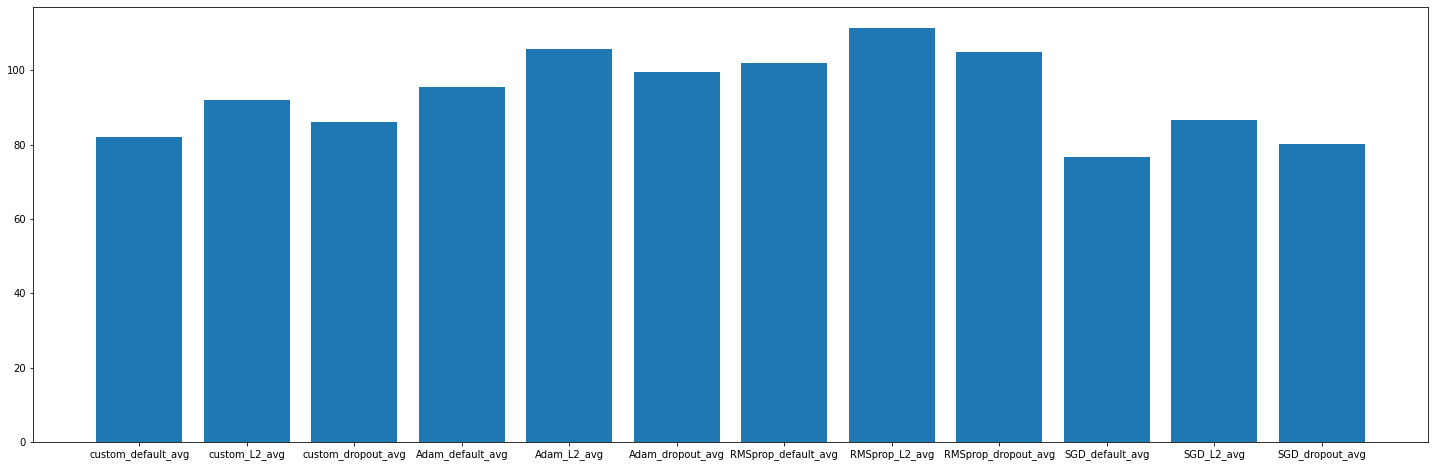

In [16]:
print ("#Average CPU time per model#")
df = pd.DataFrame(avg_cputime_dict,index = [0])
print (df.iloc[0])
plt.figure(figsize=(25,8))
plt.bar(avg_cputime_dict.keys(), avg_cputime_dict.values())

# Robustness
## Code to average accuracies in test data across trials

##Accuracy stats across trials##
   custom_default  custom_L2  custom_dropout  Adam_default  Adam_L2  \
0          0.8717     0.8737          0.8752        0.8211   0.8216   
1          0.8754     0.8721          0.8761        0.8383   0.8535   
2          0.8745     0.8749          0.8694        0.8357   0.8464   
3          0.8714     0.8753          0.8738        0.8234   0.8446   
4          0.8728     0.8742          0.8777        0.8303   0.8344   
5          0.8751     0.8773          0.8776        0.8500   0.8437   
6          0.8747     0.8769          0.8800        0.8255   0.8439   
7          0.8702     0.8713          0.8765        0.8549   0.8520   
8          0.8711     0.8719          0.8771        0.8192   0.8341   
9          0.8694     0.8724          0.8781        0.8272   0.8267   

   Adam_dropout  RMSprop_default  RMSprop_L2  RMSprop_dropout  SGD_default  \
0        0.8421           0.7271      0.7719           0.2492       0.8680   
1        0.8317           0.7

<BarContainer object of 12 artists>

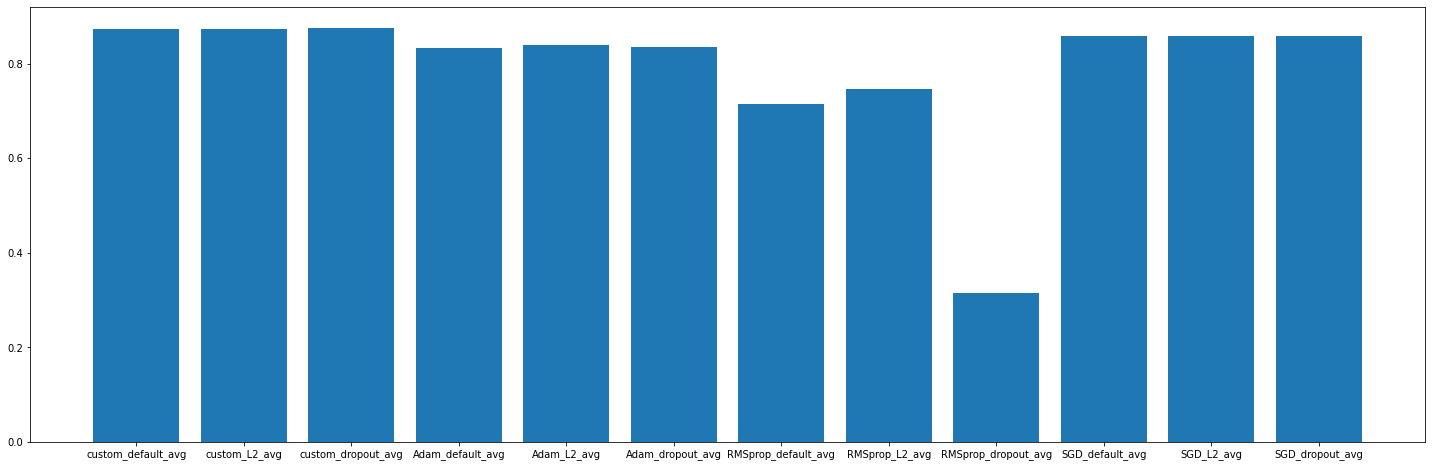

In [17]:
df = pd.DataFrame()

optimizer_list = ["custom", "Adam", "RMSprop", "SGD"]
reg_list = ["default", "L2", "dropout"]

avg_acc_dict = {}
for optim in optimizer_list:
        for reg in reg_list:
                key  = f"{optim}_{reg}"
                df[key] = data[optim][reg]["test_acc_list"]
                avg_acc_dict[key + "_avg"] = np.mean(df[key])
print ("##Accuracy stats across trials##")
print (df)
print("\n\n")

print ("#Average Accuracy per model#")
df = pd.DataFrame(avg_acc_dict,index = [0])
print (df.iloc[0])
plt.figure(figsize=(25,8))
plt.bar(avg_acc_dict.keys(), avg_acc_dict.values())

# Stability
## Code to generate average variance in loss(cce) across epochs across seeds for every model training

### I wanted to show this with plots but there were too many so I avoided that

#Average Variance in loss across seeds per model#
custom_default     2.124437e-09
custom_L2          2.271414e-09
custom_dropout     2.859384e-10
Adam_default       1.471043e-08
Adam_L2            8.894657e-09
Adam_dropout       9.679884e-09
RMSprop_default    1.500571e-04
RMSprop_L2         1.044649e-05
RMSprop_dropout    2.034020e-06
SGD_default        1.498629e-09
SGD_L2             1.550205e-09
SGD_dropout        1.342304e-09
Name: 0, dtype: float64


<BarContainer object of 12 artists>

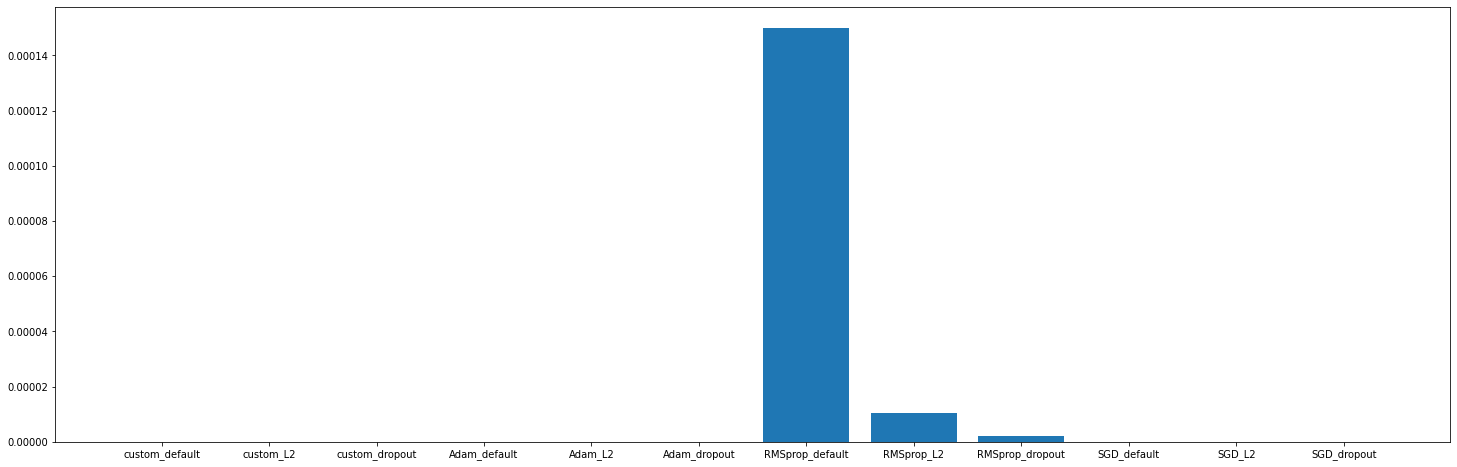

In [21]:
df = pd.DataFrame()

optimizer_list = ["custom", "Adam", "RMSprop", "SGD"]
reg_list = ["default", "L2", "dropout"]
#seeds =
variance_dict = {}
for optim in optimizer_list:
        for reg in reg_list:
                key  = f"{optim}_{reg}"
                train_cce_list_dict = data[optim][reg]["train_cce_list_dict"]
                avg_cce_list = []
                for seed in train_cce_list_dict.keys():
                        avg_cce_list.append(np.mean(train_cce_list_dict[seed]))
                variance_dict[key] = np.var(avg_cce_list)

print ("#Average Variance in loss across seeds per model#")
df = pd.DataFrame(variance_dict,index = [0])
print (df.iloc[0])
plt.figure(figsize=(25,8))
plt.bar(variance_dict.keys(), variance_dict.values())